# Description

This code is the reworked version of the original. it aims to do the cluster analysis for proteins and DNA group, as well as both simulatineoulsy and output it into a directory in csv format for furhter analyis.

In [ ]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
!mkdir vars
# supply the index to be able to select the group that is both proteins and RNA
! echo 16 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/output_no_water.xtc -pbc mol -n index.ndx -skip 10 # make the molecules whole again!
! echo 16 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/output_no_water.gro -pbc mol -n index.ndx

In [1]:
import subprocess
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import rmsd
import numpy as np
from joblib import Parallel, delayed
import os
import networkx as nx
import csv
xtc_file = "vars/output_no_water.xtc"
gro_file = "vars/output_no_water.gro"
u= mda.Universe(gro_file, xtc_file)
# test with unwrapped
#u= mda.Universe("unwrapped_no_water.gro", "unwrapped_no_water.xtc")

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
rna_start = NUM_PROTEINS * PROTEIN_LEN
print(rna_start) # gives the start of the RNA section

proteins = []




/opt/conda/envs/gromacs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


29580


In [2]:
import matplotlib.pyplot as plt

# This function is for plotting clusterizations
def plot_cluster(clusters_per_frame, cutoff, min_clust_size, mode):
    num_clusters = [len(clusters) for clusters in clusters_per_frame.values()]
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(num_clusters)), num_clusters,label='Number of Clusters ', marker='o', markersize=4)
    plt.xlabel("Frame")
    plt.ylabel("Number of Clusters")
    plt.title(f"Num Clusters. Cutoff ={cutoff}A min_clustsize{min_clust_size}. {mode}")
    plt.legend()
    plt.show

    average_cluster_sizes = []
    frames = []

    # increase n to average over frames and reduce noise
    avg_over_n = 0
    for frame, clusters in clusters_per_frame.items():
        total_size = sum(len(cluster) for cluster in clusters)
        avg_size = total_size / len(clusters) if clusters else 0 # make sure to handle 0 case
        average_cluster_sizes.append(avg_size)

        frames.append(frame)

    plt.figure(figsize=(12, 6))
    plt.plot(frames, average_cluster_sizes, label='Average Cluster Size', marker='o', markersize=4)
    plt.xlabel('Frame')
    plt.ylabel('Average Cluster Size')
    plt.title(f'Average Cluster Size vs Frame. Cutoff ={cutoff}A min_clustsize{min_clust_size}. {mode}')
    plt.grid(True)
    plt.show()
    return frames

def get_minimal_distance(u, group_a, group_b):
    # Preallocate arrays
    com_dist = []
    for i, ts in enumerate(u.trajectory):
        res_com1 = group_a.center_of_mass(compound='residues')
        res_com2 = group_b.center_of_mass(compound='residues')
         
        com_dist.append(np.min(distances.distance_array(res_com1, res_com2,
                                    box=u.dimensions)))
    return com_dist


# the offset here is not used but needed so there is no error
def compute_dist_for_prot_prot(i, j, offset):
    u= mda.Universe(gro_file, xtc_file)
    group_a = u.select_atoms(f"bynum {i * PROTEIN_LEN + 1}:{(i + 1) * PROTEIN_LEN}")
    group_b = u.select_atoms(f"bynum {j * PROTEIN_LEN + 1}:{(j + 1) * PROTEIN_LEN}")
    return (i, j, get_minimal_distance(u, group_a, group_b))

def compute_dist_for_rna_rna(i, j, offset):
    # the only difference here is that it uses the RNA_LEN variable and adds offset for indexing
    u= mda.Universe(gro_file, xtc_file)
    # we need this offset to skip the proteins
    group_a = u.select_atoms(f"bynum {i * RNA_LEN + 1+offset}:{(i+1) * RNA_LEN+offset}")
    group_b = u.select_atoms(f"bynum {j* RNA_LEN +1 + offset}:{(j+1) * RNA_LEN + offset}")
    return (i, j, get_minimal_distance(u, group_a, group_b))
    
def compute_dist_fot_prot_rna(i, j, offset):
    """This computes minimal distances between the proteins and RNA molecules. 
    It is important to keep in mind the offset for the RNA and no offset for the proteins.
    Thus, we need to check if the molecule is protein or RNA. I am going to do it based on it's index
    with the assumption that proteins come first."""
    u = mda.Universe(gro_file, xtc_file)
    if i < NUM_PROTEINS:
        # in this case we know I is pointing to a protein
        group_a = u.select_atoms(f"bynum {i * PROTEIN_LEN + 1}:{(i+1) * PROTEIN_LEN}")

    else:
        # if i is bigger than the number of proteins, then we know that it must be the rna
        group_a = u.select_atoms(f"bynum {(i-NUM_PROTEINS) * RNA_LEN + 1+offset}:{(i+1-NUM_PROTEINS) * RNA_LEN+offset}")
 
    if j < NUM_PROTEINS:
        group_b = u.select_atoms(f"bynum {j * PROTEIN_LEN + 1}:{(j + 1) * PROTEIN_LEN}")
    else:    
        group_b = u.select_atoms(f"bynum {(j-NUM_PROTEINS)*RNA_LEN +1 + offset}:{(j+1-NUM_PROTEINS) * RNA_LEN + offset}")
    # I am not checking the out of bounds access here by index so as no not slow it down.
    if group_a.n_atoms == 0:
        print(group_a)
        print("help gorup a is empty")
    if group_b.n_atoms == 0:
        print(group_b)
        print(j)
        print(f"bynum {j*RNA_LEN +1 + offset}:{(j+1) * RNA_LEN + offset}")
        print("help gorup b is empty")
    # if len(group_a) == 0 or len(group_b) == 0:
    #     print("help gorup is empty")
    #     exit
    return (i, j, get_minimal_distance(u, group_a, group_b))

    
    
def parallel_dist_calculation(num_proteins, num_frames, mode, offset):
    """Parallel computation for all pairs of proteins across all frames."""
    # depending on the case the pareallel calculation will run on funcitons that select different molecules
    if mode == "prot-prot":
        func = compute_dist_for_prot_prot
        matrix_size = num_proteins # consider only protein molecules
    elif mode == "rna-rna":
        func = compute_dist_for_rna_rna
        matrix_size = NUM_RNA # consider only rna molecules
    elif mode == "prot-rna":
        func = compute_dist_fot_prot_rna
        matrix_size = NUM_RNA + num_proteins # we consider both types of molecules
        print(f"matrix size is {matrix_size}")
    else:
        print("fatal error: invalid mode chosen")
        exit # invalid mode chosen
    dist_3d = np.zeros((num_frames, matrix_size, matrix_size))
    results = Parallel(n_jobs=32)(
        delayed(func)(i, j, offset)
        for i in range(matrix_size)
        for j in range(i, matrix_size)
    )
    # Populate the 3D array
    for i, j, dist_frames in results:
        dist_3d[:, i, j] = dist_frames  # Upper triangle
        dist_3d[:, j, i] = dist_frames  # Symmetric lower triangle
    return dist_3d

def graph_based_clustering(distance_matrix, cutoff):
    """
    Perform graph-based clustering for a single frame.
    Nodes are connected if RMSD is below the cutoff.
    """
    num_proteins = distance_matrix.shape[0]
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(num_proteins))

    # Add edges for pairs below the cutoff
    for i in range(num_proteins):
        for j in range(i + 1, num_proteins):
            if distance_matrix[i, j] < cutoff:
                G.add_edge(i, j)

    # Find connected components (clusters)
    clusters = [list(component) for component in nx.connected_components(G)]
    return clusters

# min clustsize allows to set the minimal size that counts as a cluster
def cluster_all_frames(rmsd_3d, cutoff, min_clust_size=0, mode="prot-prot"):
    """
    Perform clustering for each frame in the trajectory.
    """
    num_frames = rmsd_3d.shape[0]
    clusters_per_frame = {}

    for frame_idx in range(num_frames):
        rmsd_matrix = rmsd_3d[frame_idx]
        clusters = graph_based_clustering(rmsd_matrix, cutoff)
        #print(len(clusters))
        #num_big_clusters = 0
        big_clusters = []
        for clustah in clusters:
            #print(clustah)
            if len(clustah) >= min_clust_size:
                big_clusters.append(clustah)
                #num_big_clusters += 1
        clusters_per_frame[frame_idx] = big_clusters
        # print(clusters_per_frame[frame_idx])
        # this needs to be fixed
        # if len(clusters) >= min_clust_size:
        #     clusters_per_frame[frame_idx] = clusters

    # write the clustered results into a csv
    result_path = "results/clustering/"
    if not os.path.isdir(result_path):
        os.makedirs(result_path, exist_ok=True)
    with open(result_path+str(mode)+"_cutoff"+str(cutoff)+ "_minsize"+str(min_clust_size) + ".csv", "w") as file:
        fieldnames = ['Frame Number', 'Number of Clusters']
        writer = csv.DictWriter(file, fieldnames) 
        writer.writeheader()
        for frame_idx, clusts in clusters_per_frame.items():
            writer.writerow({'Frame Number': frame_idx, 'Number of Clusters': len(clusts)})
            
    frames = plot_cluster(clusters_per_frame, cutoff, min_clust_size, mode)    
    return clusters_per_frame

def run_distance_by_type(mode, num_frames, cutoffs, min_clust_sizes):
    if mode == "prot-prot":
        if not os.path.isfile(f"vars/protein_dist_3d_array.npy"):
            offset = 0
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/protein_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/protein_dist_3d_array.npy")
    elif mode == "rna-rna":
        offset = NUM_PROTEINS * PROTEIN_LEN
        if not os.path.isfile(f"vars/rna_dist_3d_array.npy"):
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/rna_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/rna_dist_3d_array.npy")        
    elif mode == "prot-rna":
        offset = NUM_PROTEINS * PROTEIN_LEN
        if not os.path.isfile(f"vars/prot-rna_dist_3d_array.npy"):
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/prot-rna_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/prot-rna_dist_3d_array.npy")
    else:
        print("fatal error: invalid mode chosen")
        exit # invalid mode chosen
    
    clusts = []
    for cutoff in cutoffs:
        for min_clust_size in min_clust_sizes:
            clusts.append(cluster_all_frames(dist_3d_array, cutoff, min_clust_size, mode))    
    
    return dist_3d_array

created Universe
running distance calculations foir protein
matrix size is 60


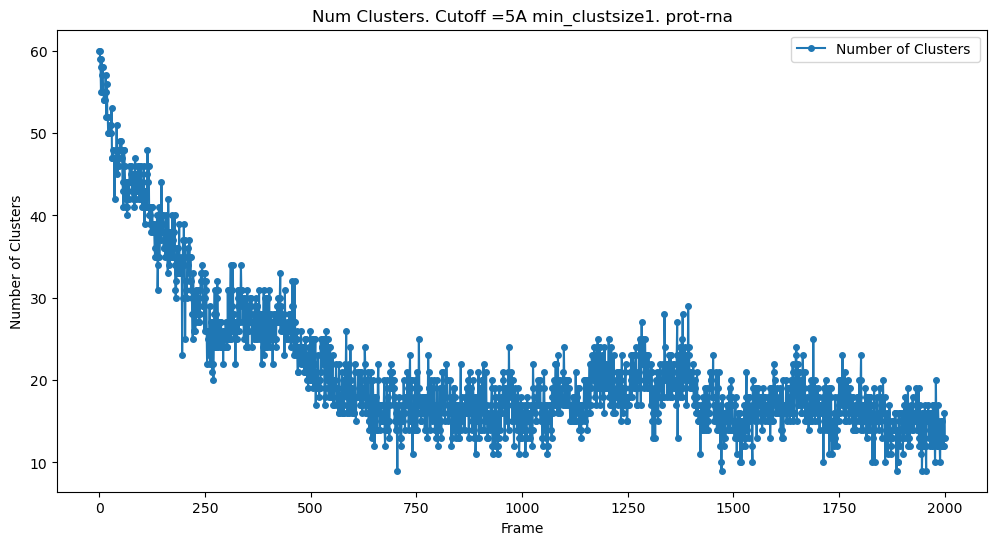

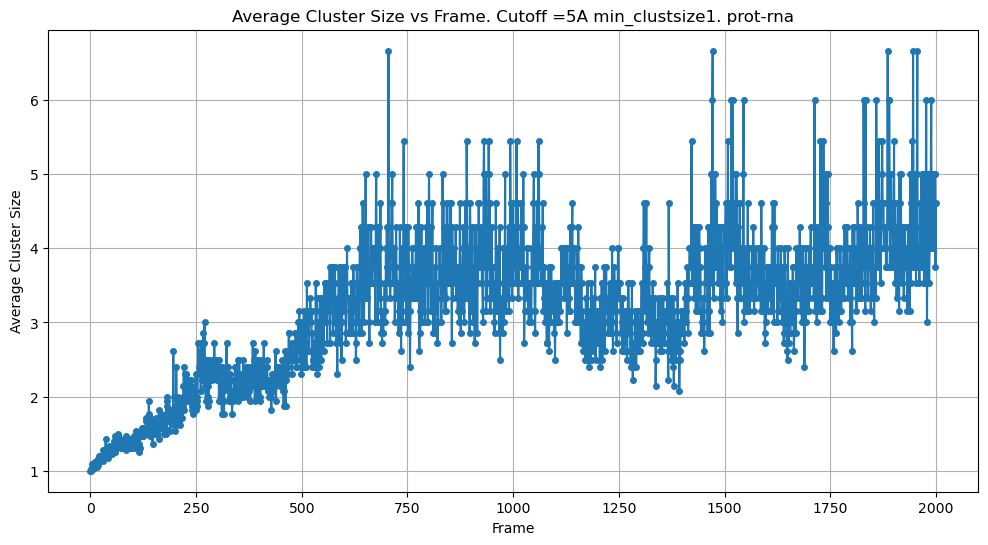

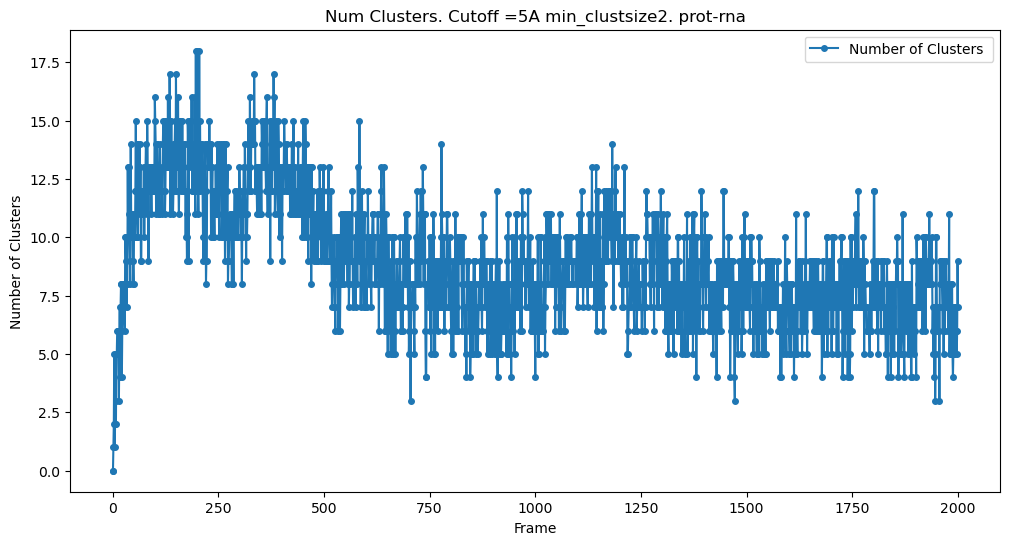

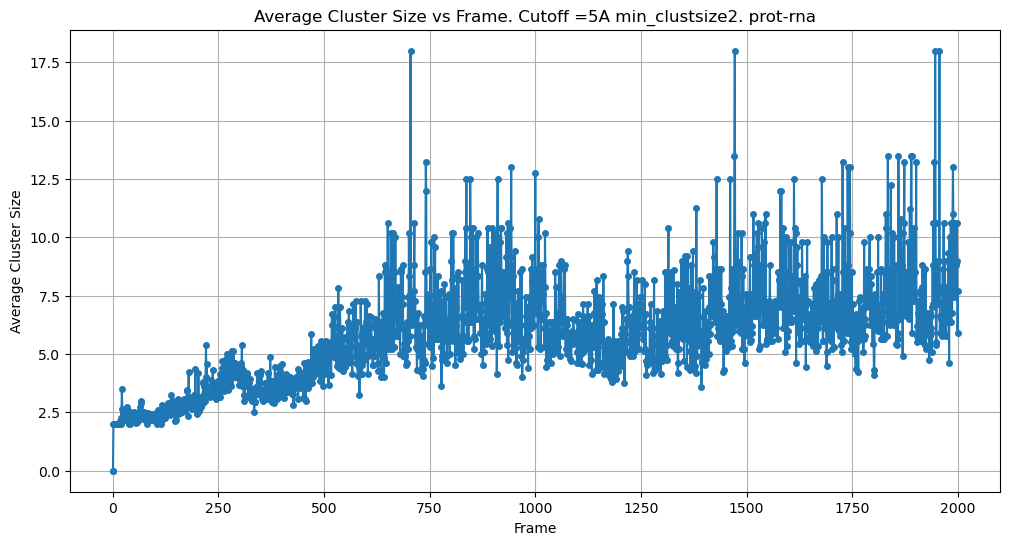

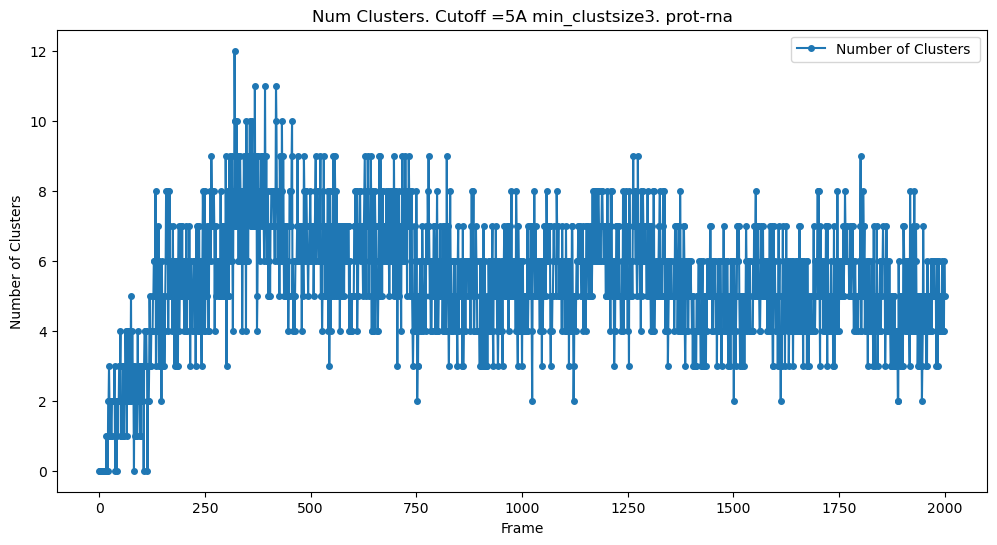

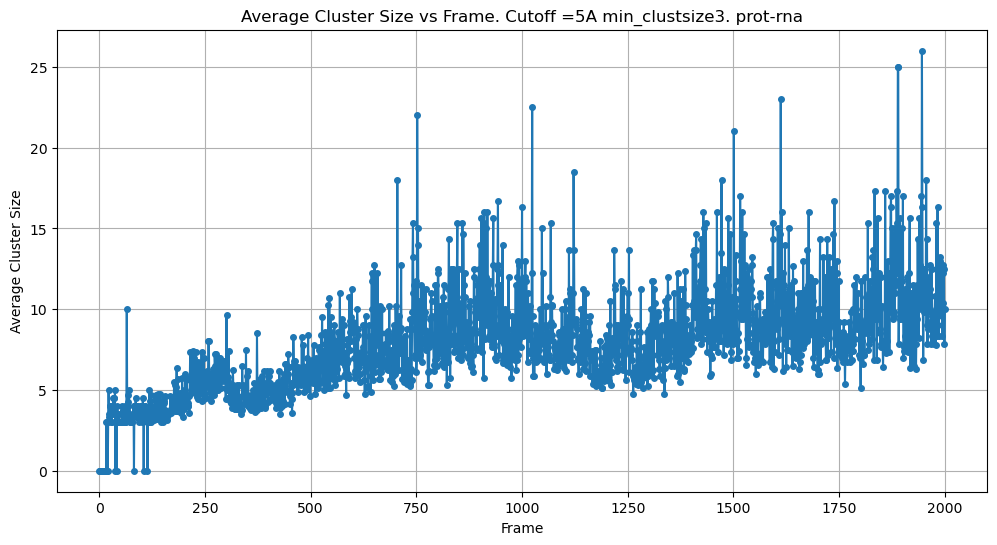

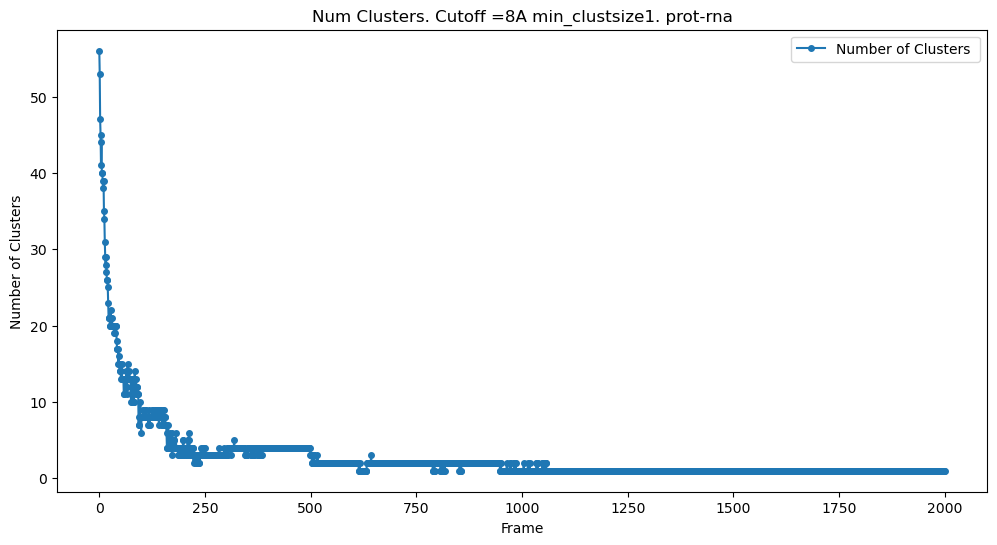

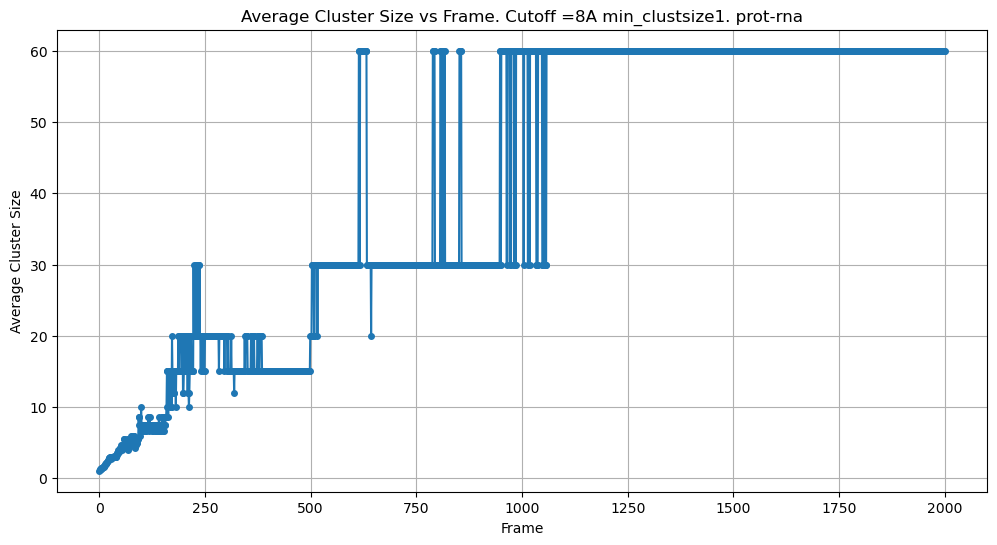

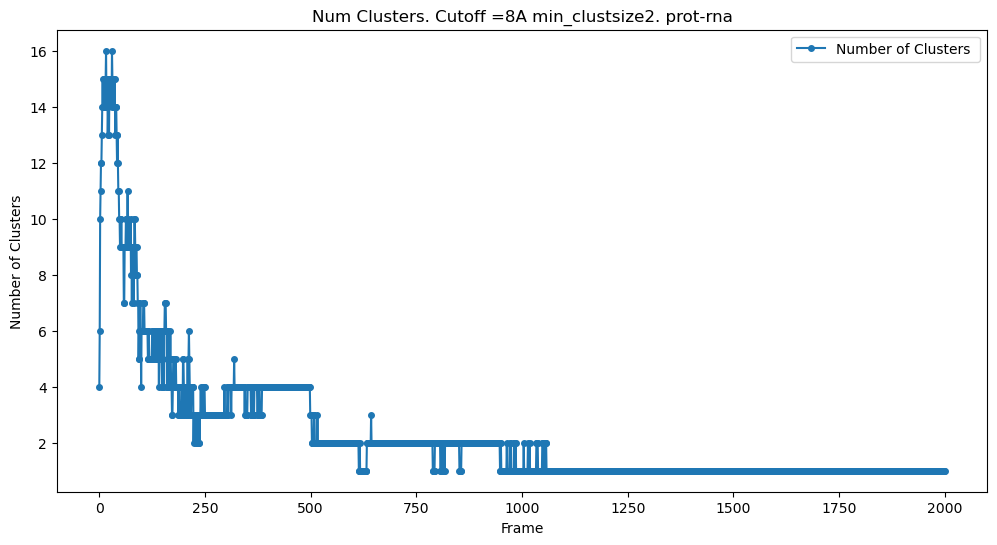

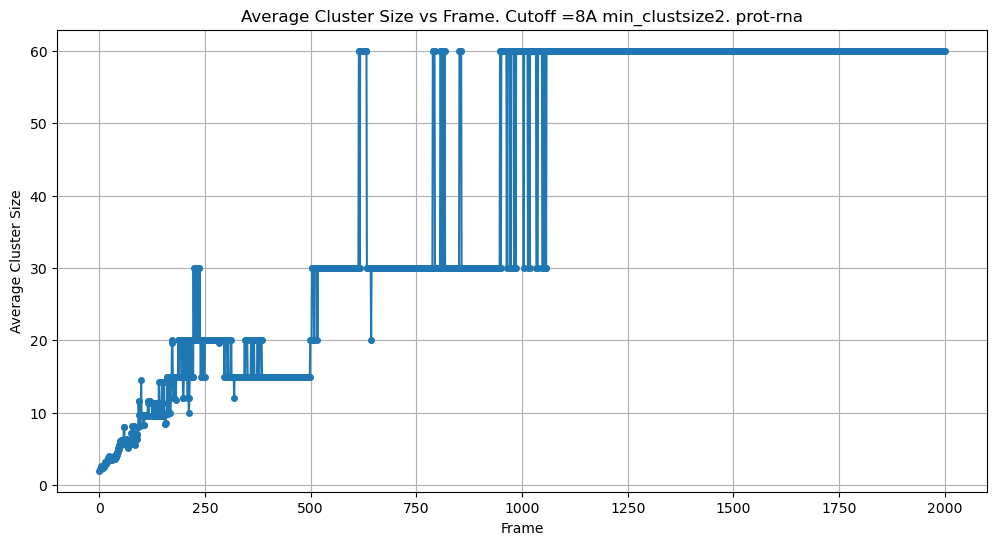

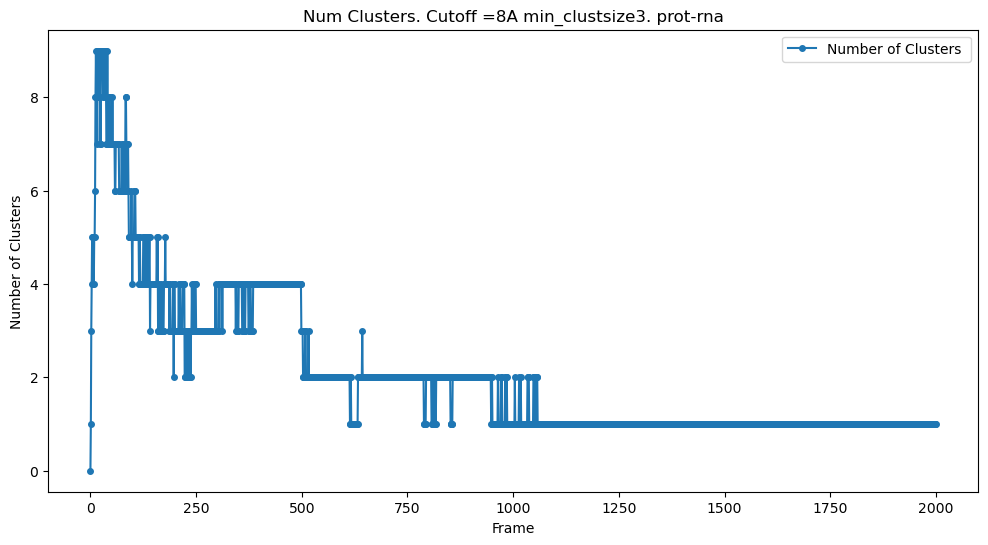

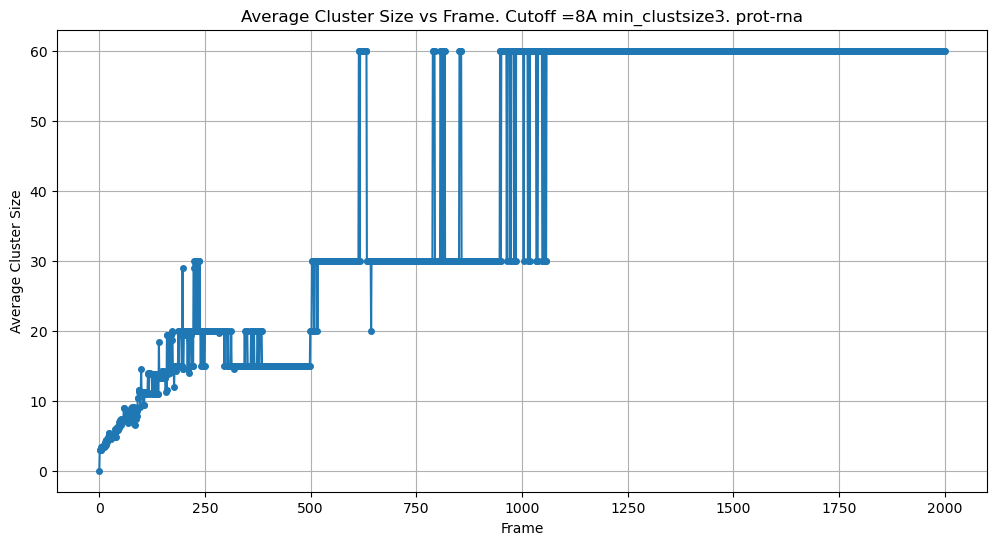

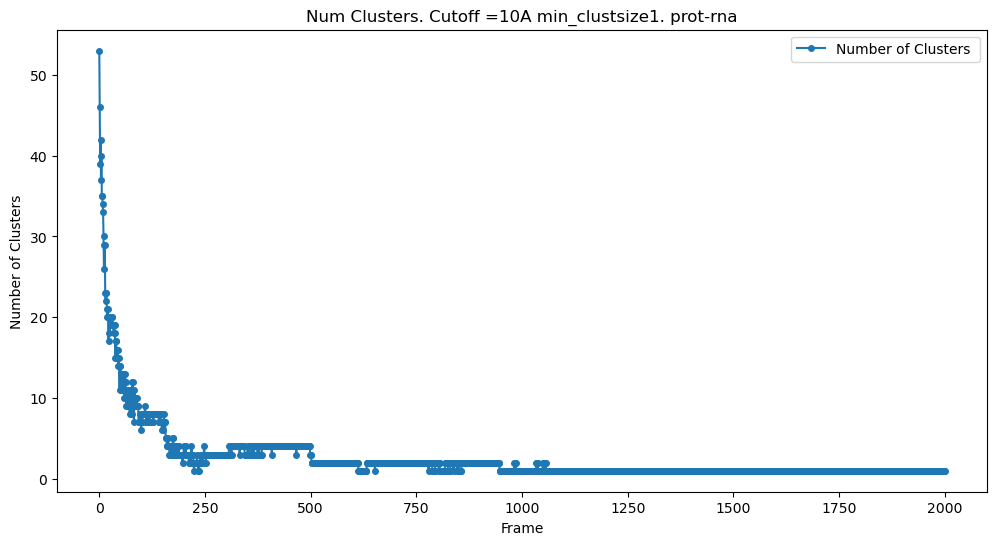

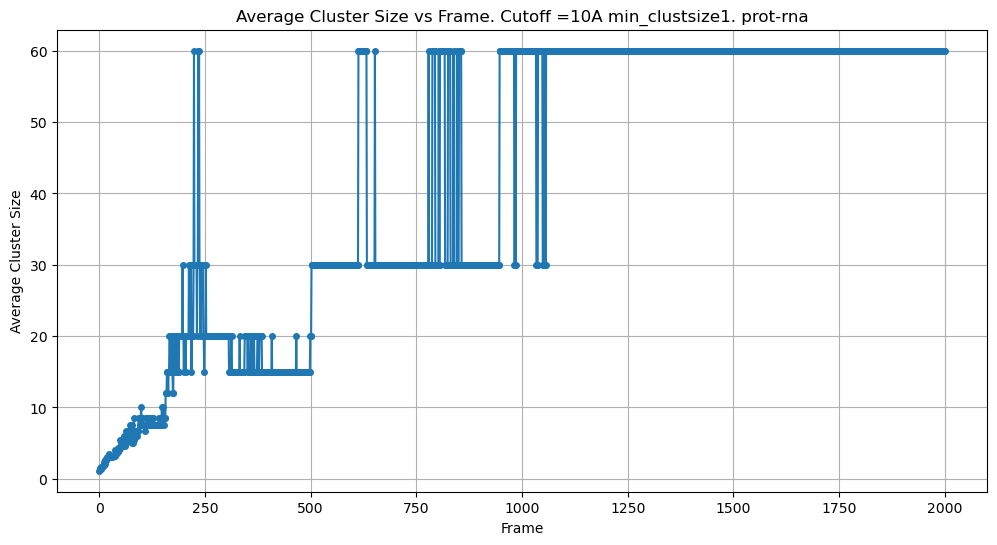

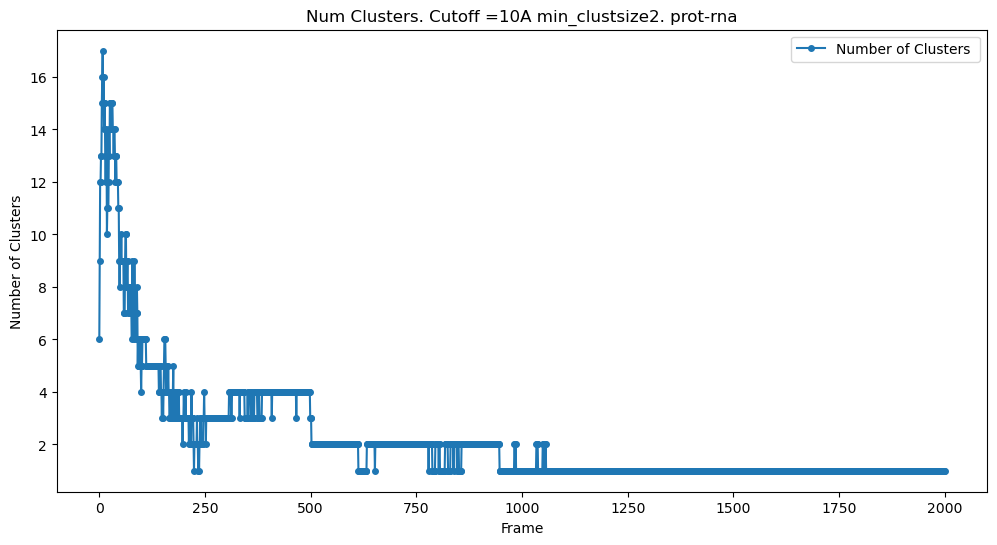

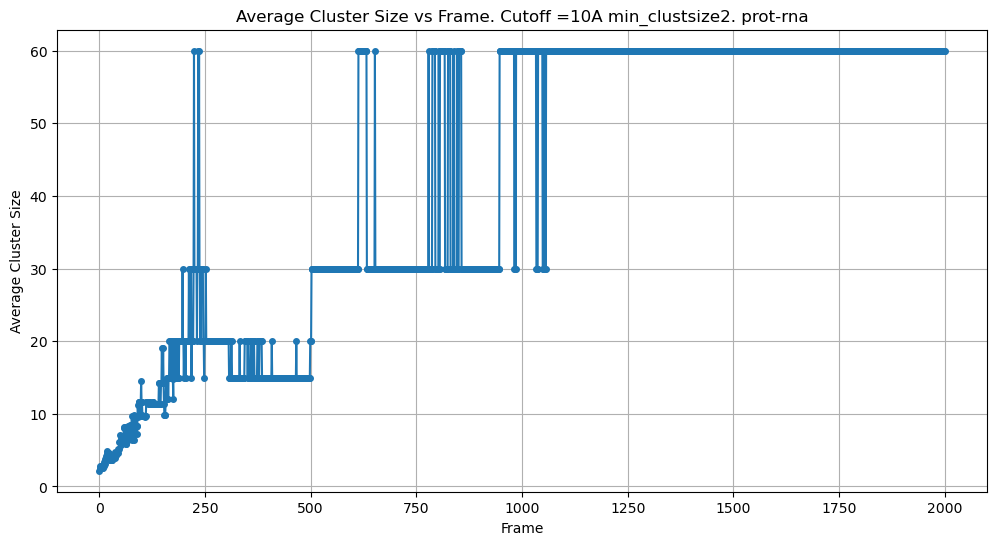

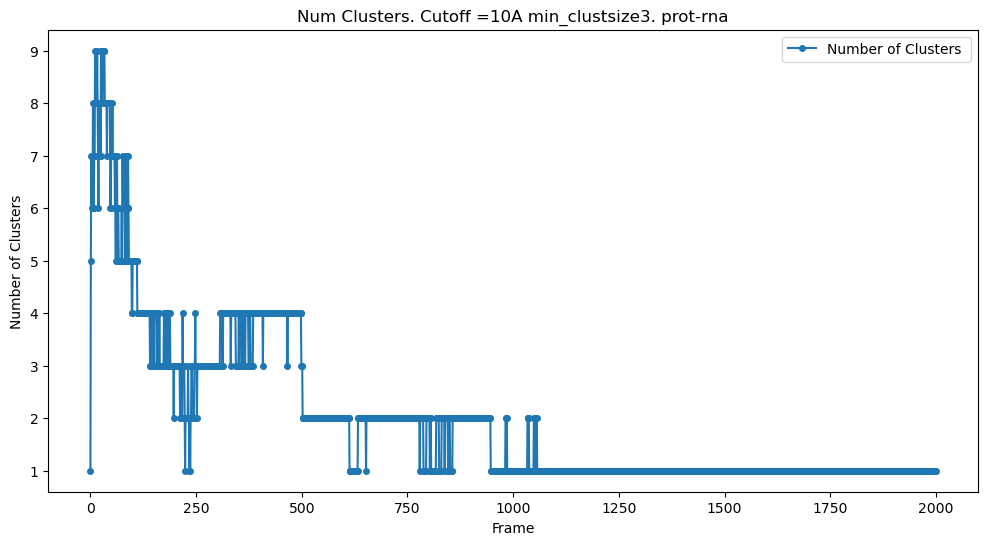

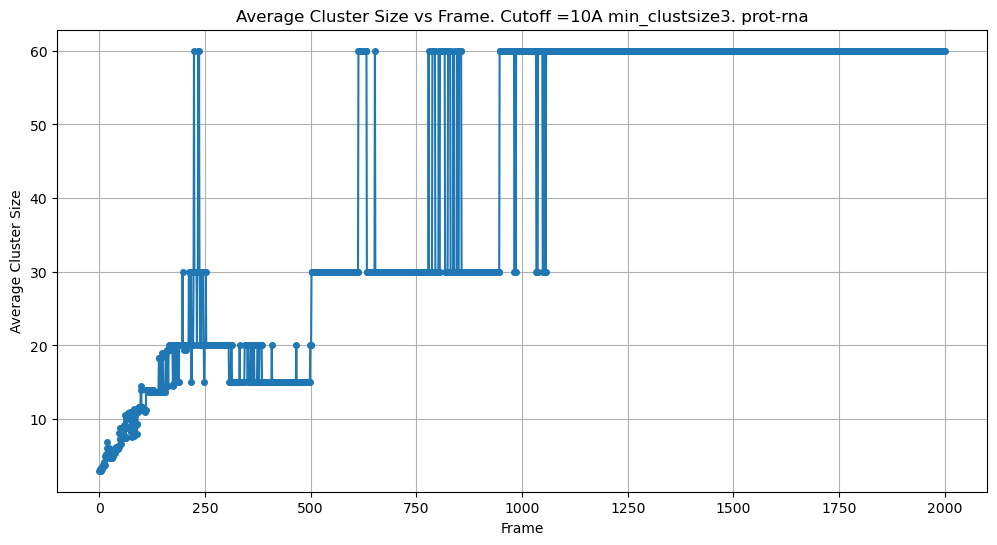

In [3]:
modes = [ "prot-rna"]


def run_distance_by_type(mode, num_frames, cutoffs, min_clust_sizes):
    if mode == "prot-prot":
        if not os.path.isfile(f"vars/protein_dist_3d_array.npy"):
            offset = 0
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/protein_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/protein_dist_3d_array.npy")
    elif mode == "rna-rna":
        offset = NUM_PROTEINS * PROTEIN_LEN
        if not os.path.isfile(f"vars/rna_dist_3d_array.npy"):
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/rna_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/rna_dist_3d_array.npy")        
    elif mode == "prot-rna":
        offset = NUM_PROTEINS * PROTEIN_LEN
        if not os.path.isfile(f"vars/prot-rna_dist_3d_array.npy"):
            print("running distance calculations foir protein")
            dist_3d_array = parallel_dist_calculation(NUM_PROTEINS, num_frames, mode, offset)
            np.save(f"vars/prot-rna_dist_3d_array.npy", dist_3d_array)
        else:
            dist_3d_array = np.load(f"vars/prot-rna_dist_3d_array.npy")
    else:
        print("fatal error: invalid mode chosen")
        exit # invalid mode chosen
    
    clusts = []
    for cutoff in cutoffs:
        for min_clust_size in min_clust_sizes:
            clusts.append(cluster_all_frames(dist_3d_array, cutoff, min_clust_size, mode))    
    
    return dist_3d_array

cutoffs = [5, 8, 10]
min_clust_sizes = [1, 2, 3]    
u= mda.Universe(gro_file, xtc_file)
print("created Universe")
for mode in modes:
    # the return variable is just so I can later play around with it and visualize it using in matplotlib
    dist_3d_array = run_distance_by_type(mode, len(u.trajectory), cutoffs, min_clust_sizes)


created Universe
running distance calculations foir protein


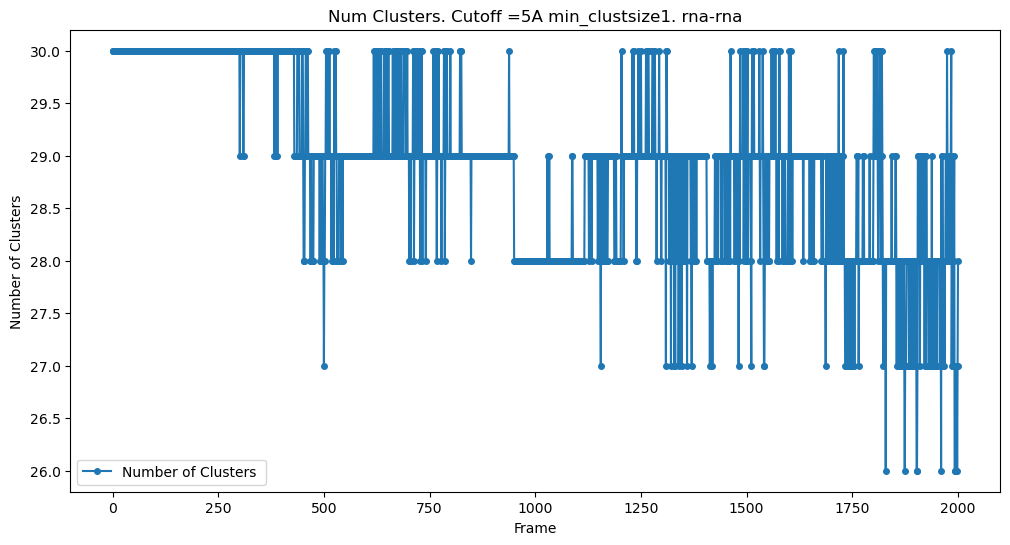

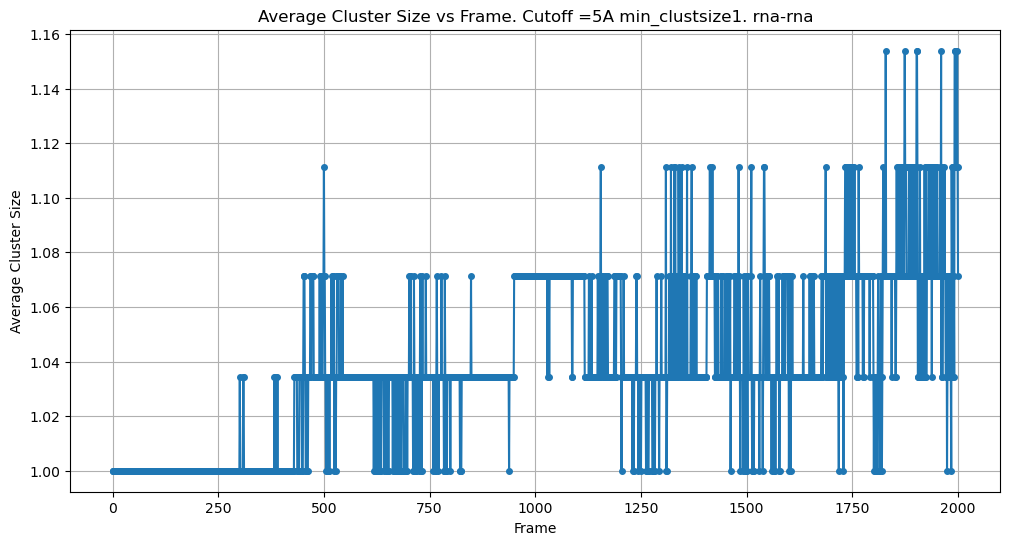

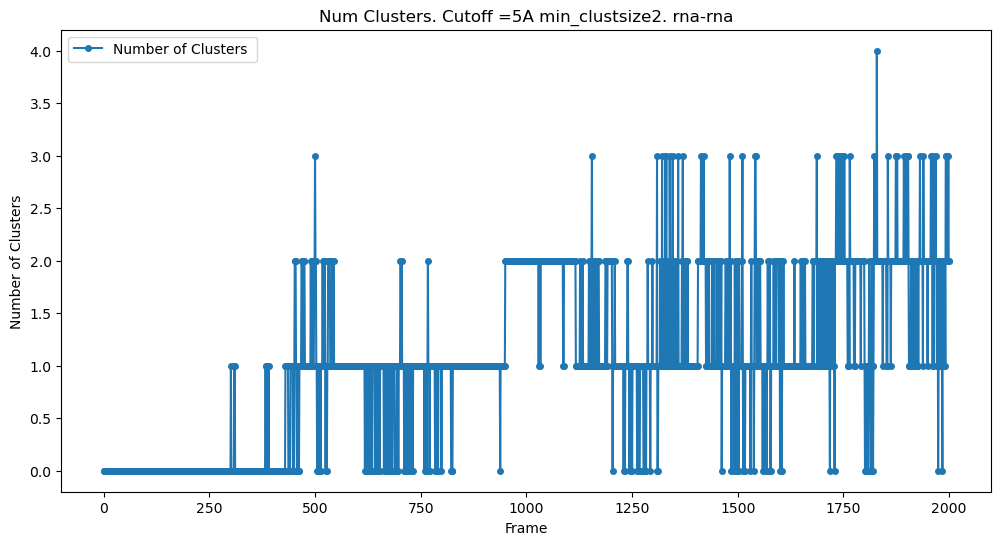

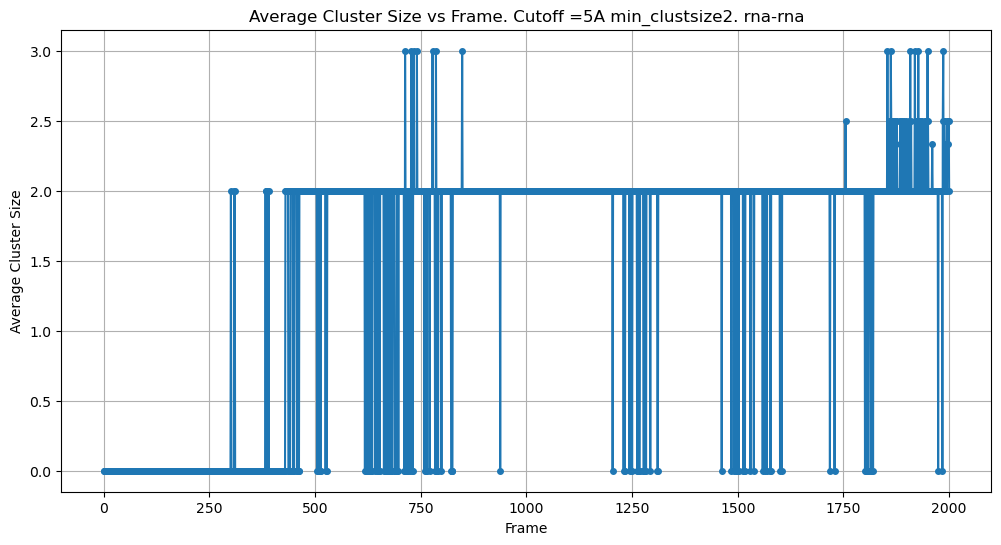

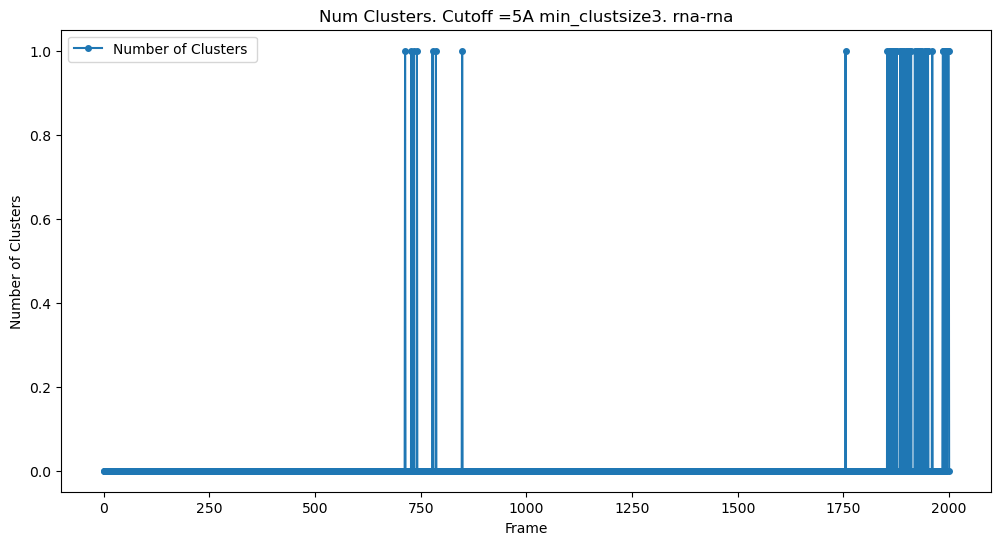

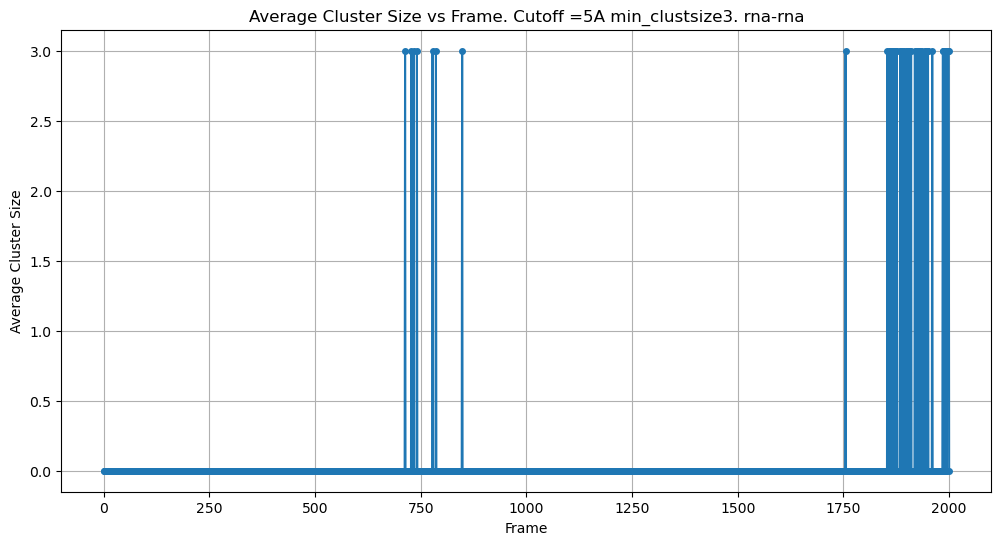

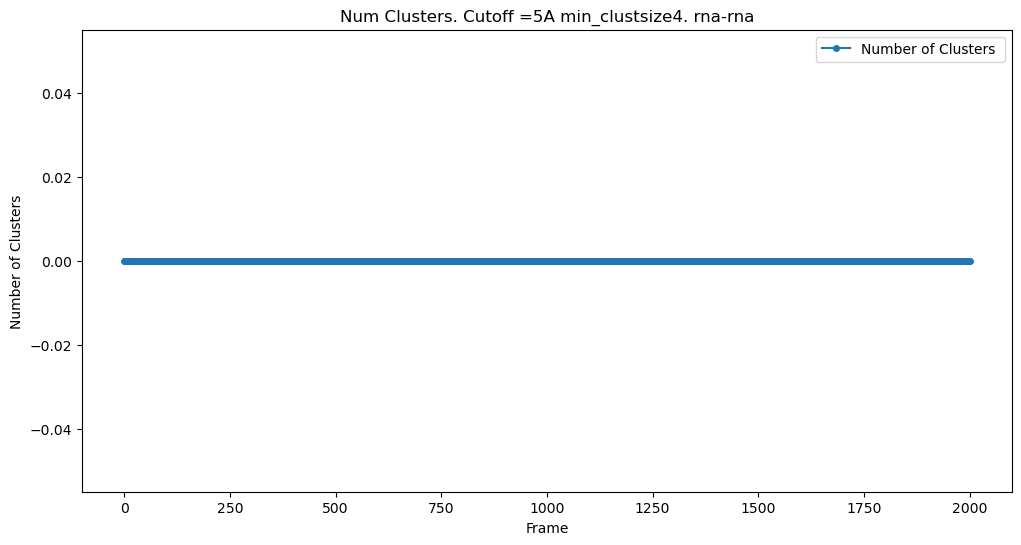

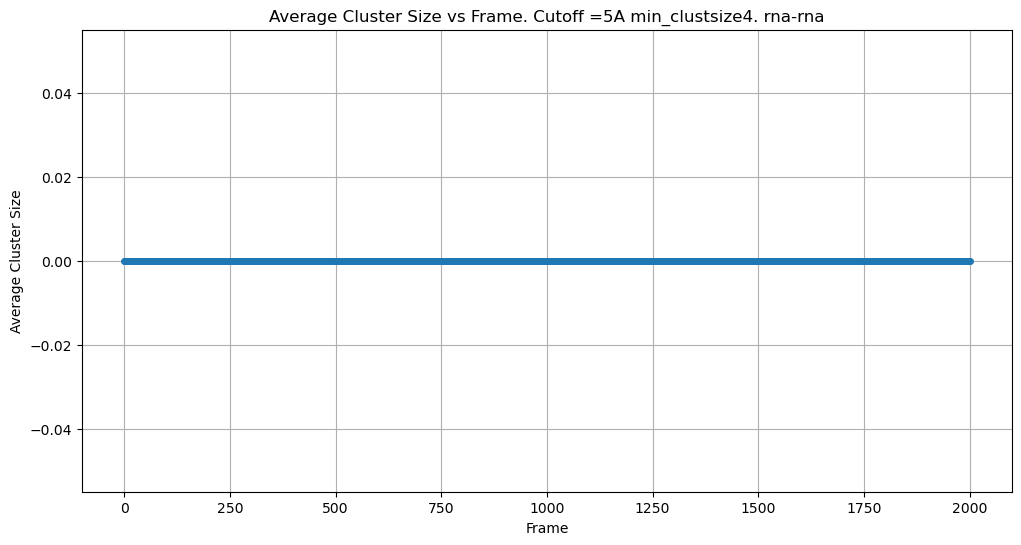

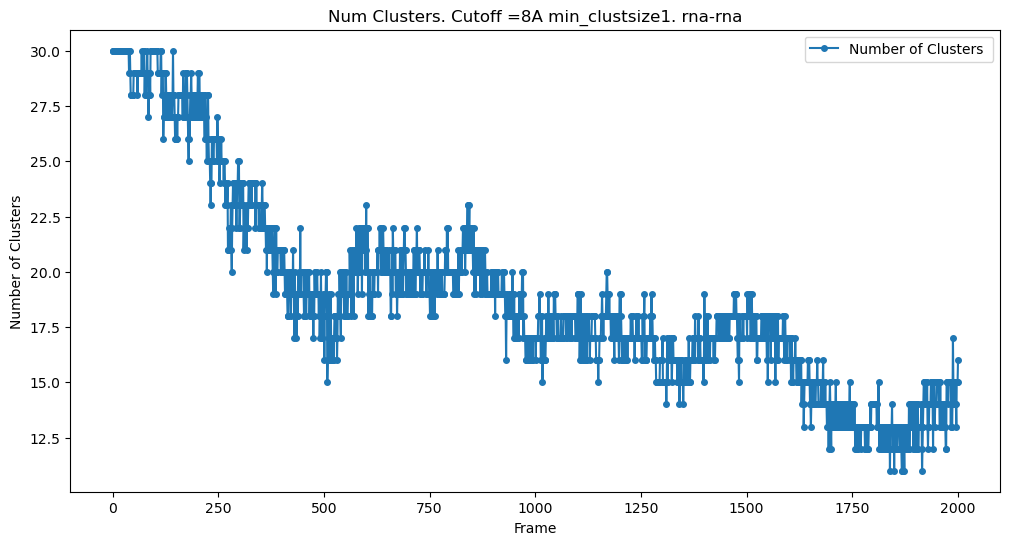

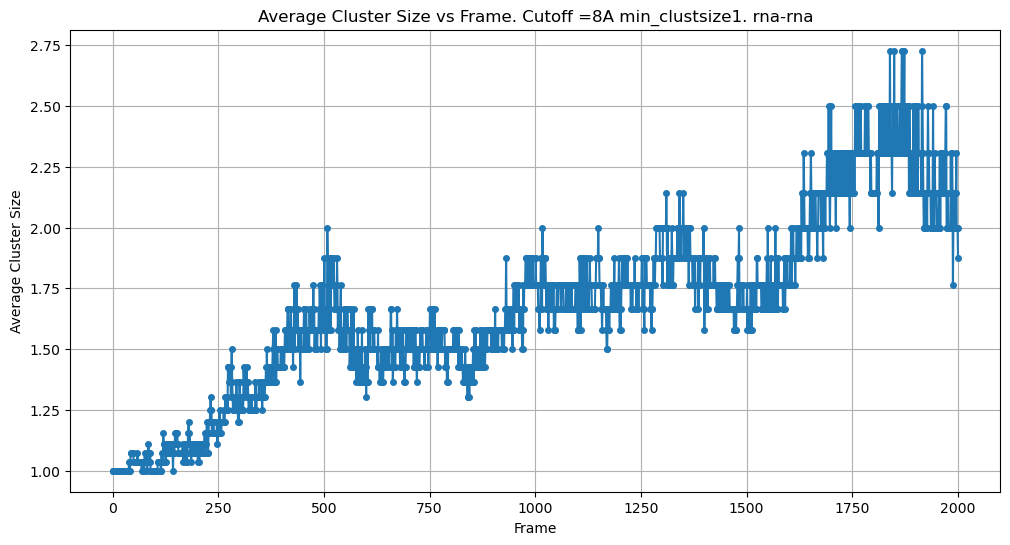

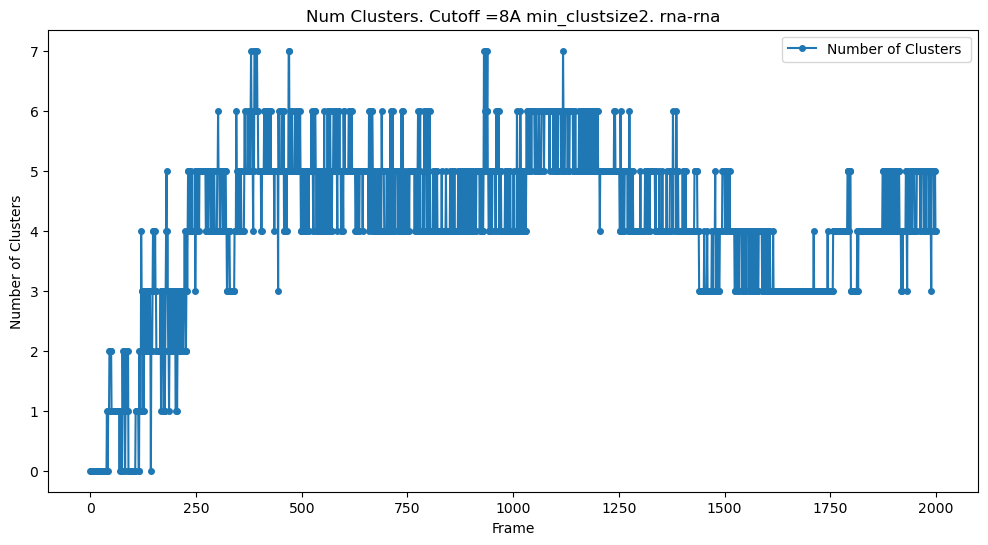

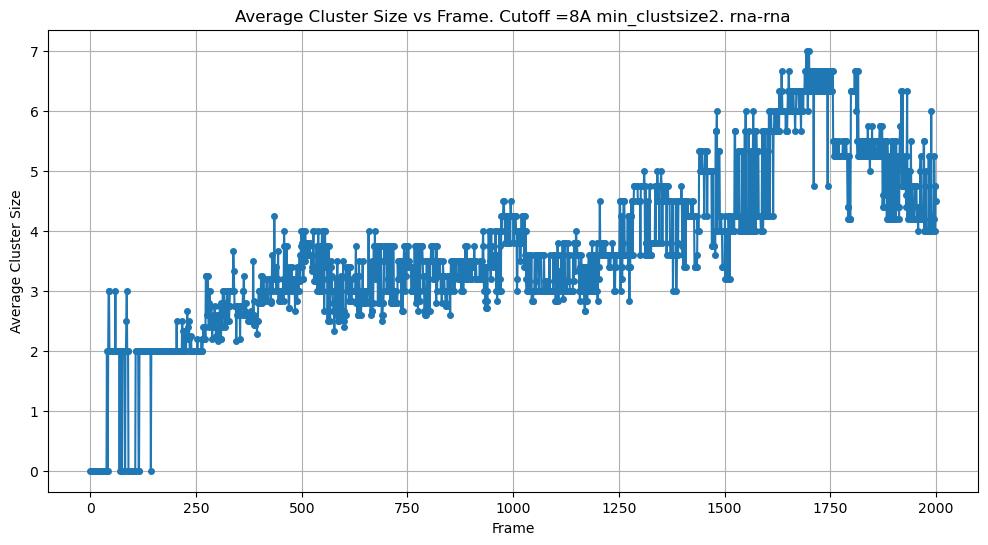

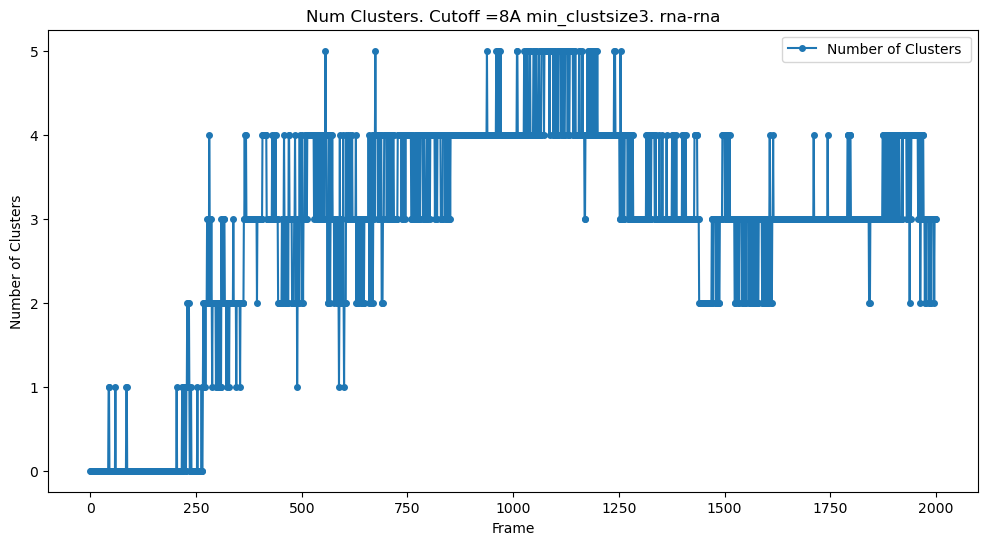

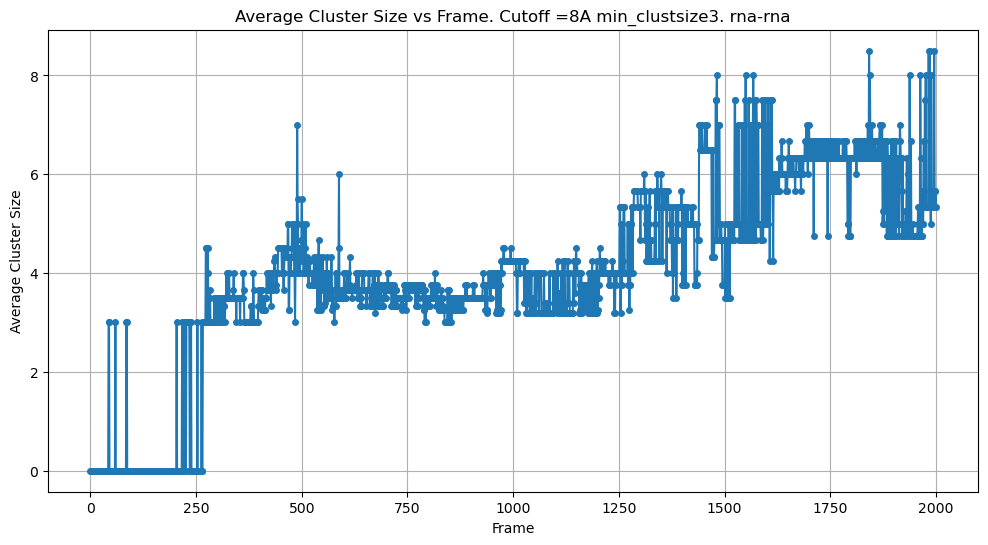

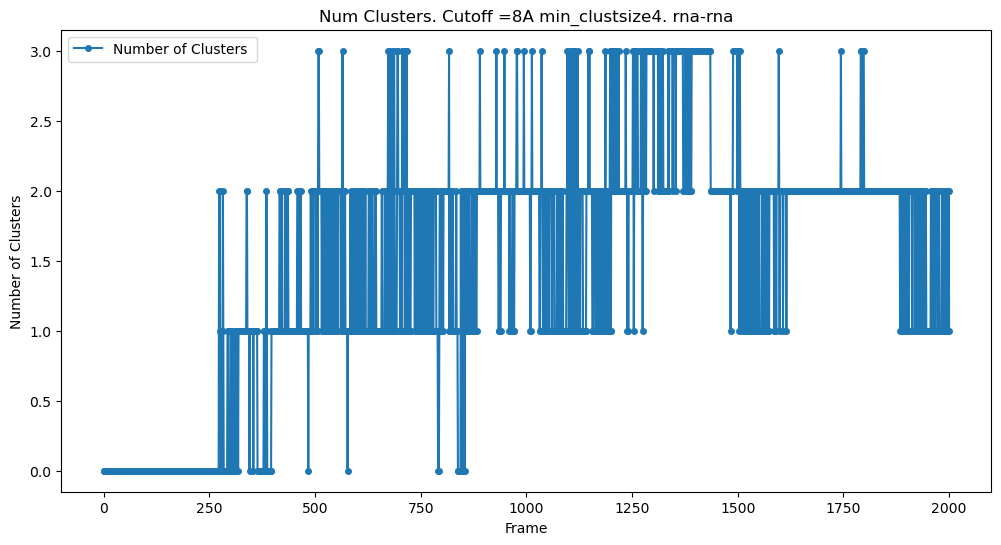

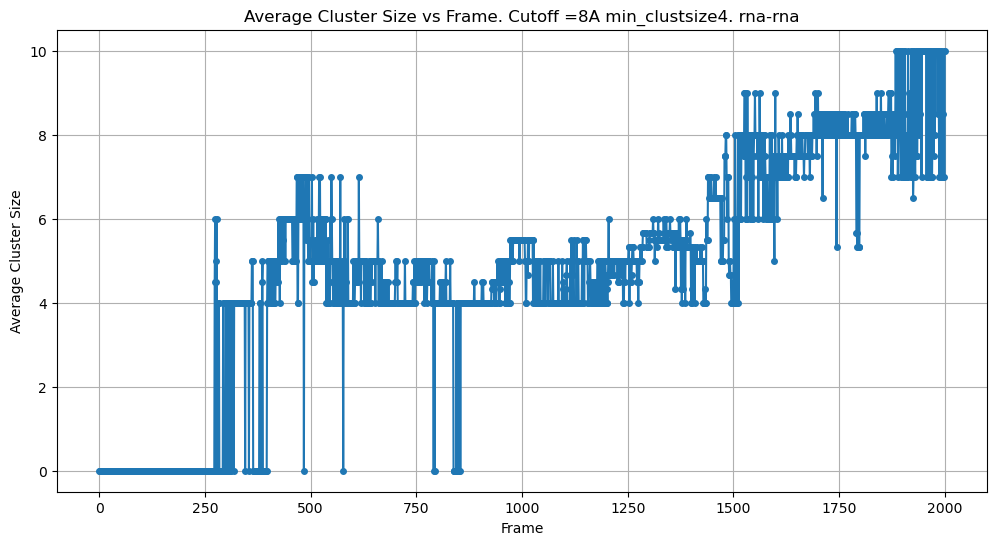

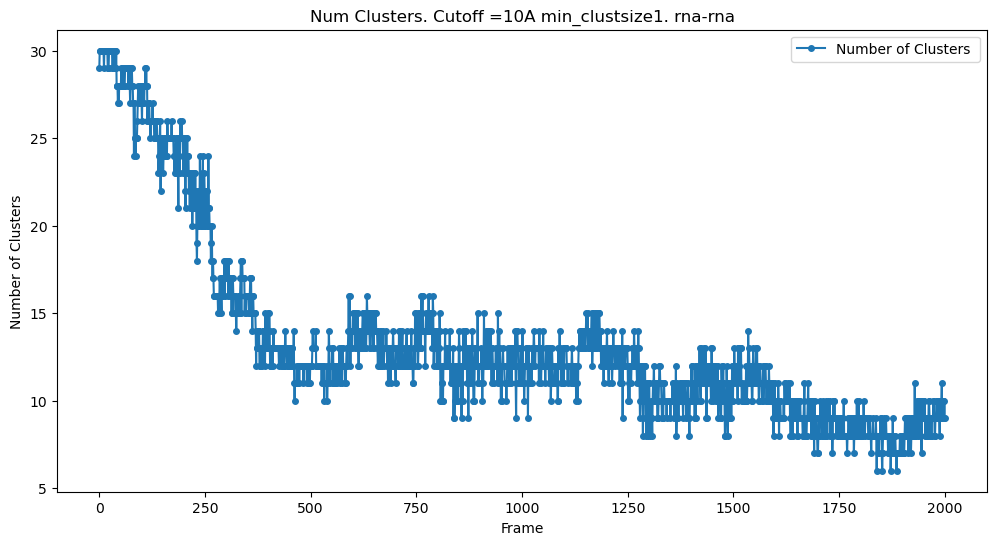

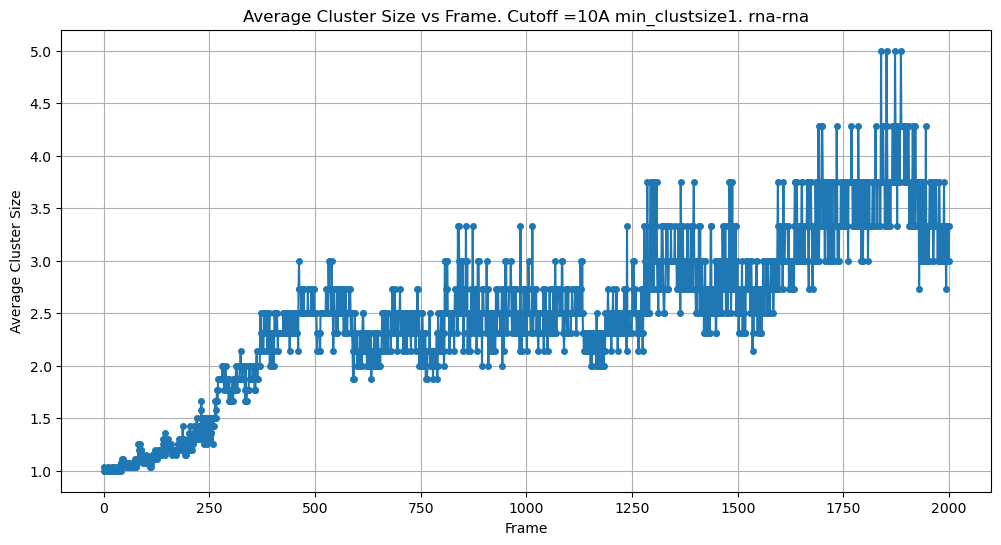

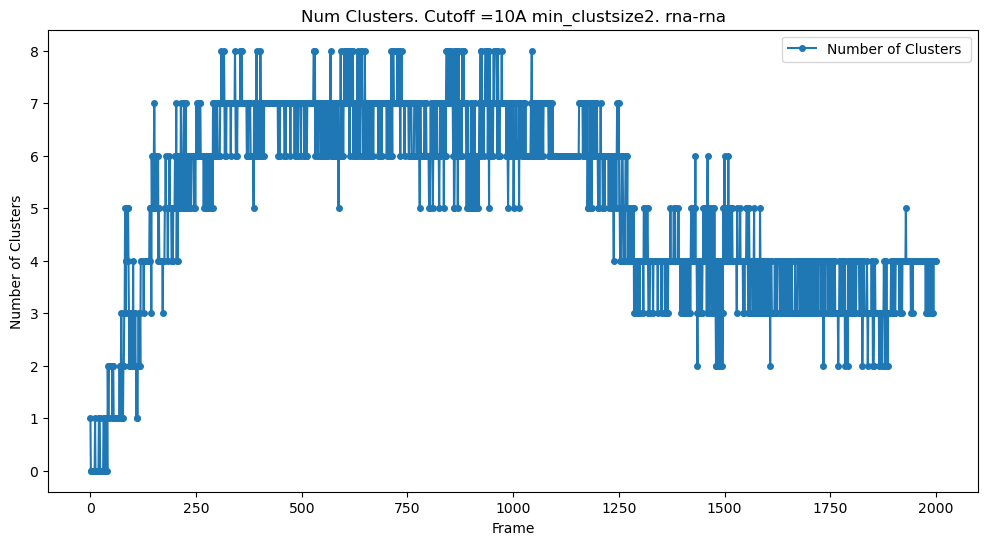

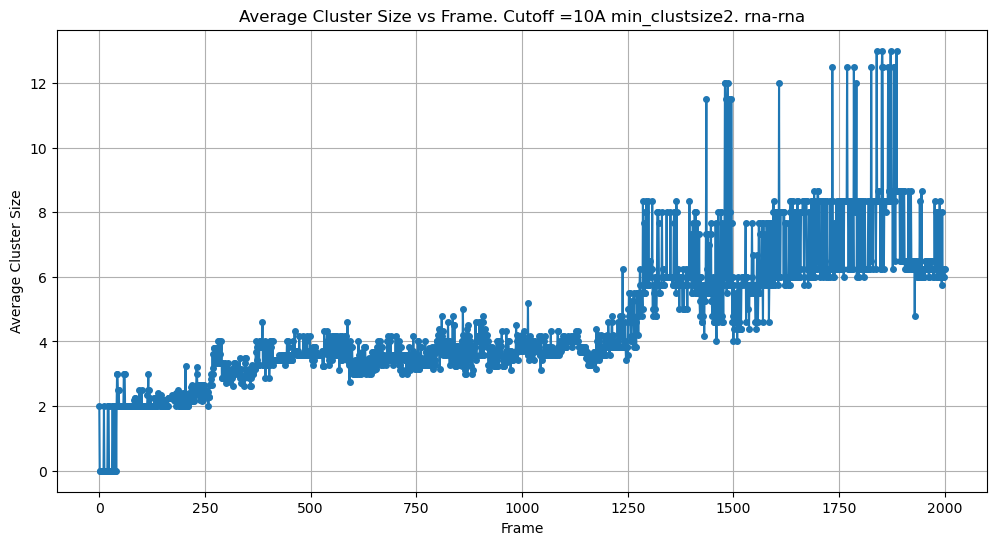

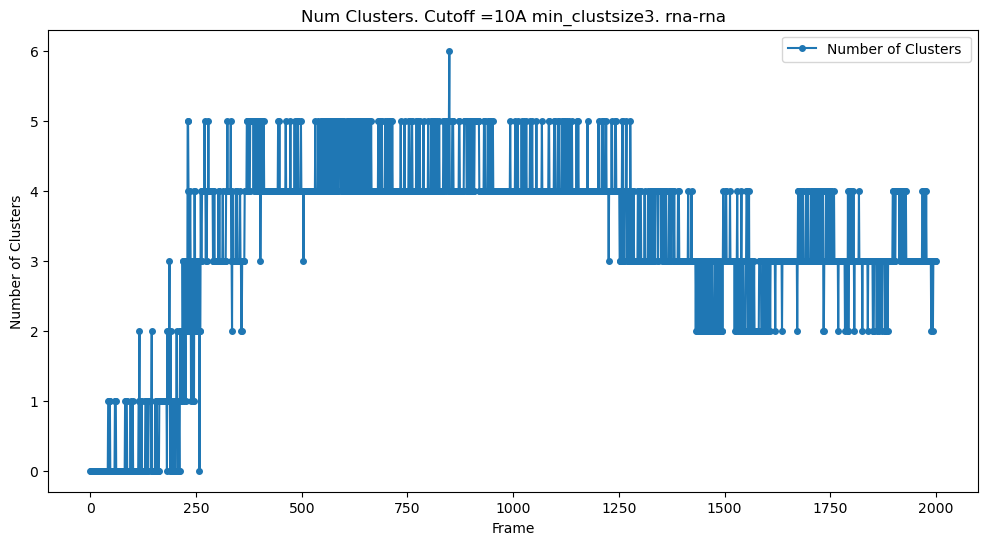

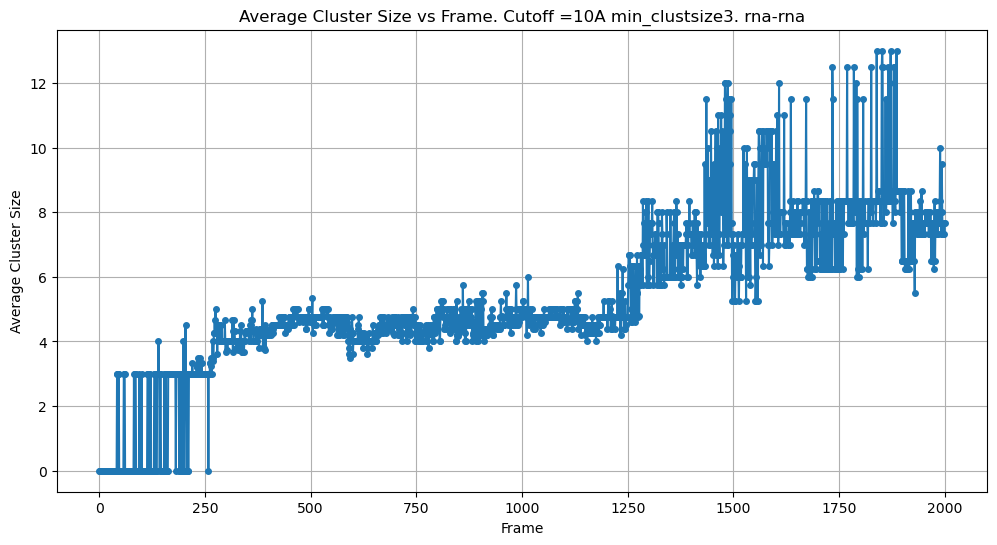

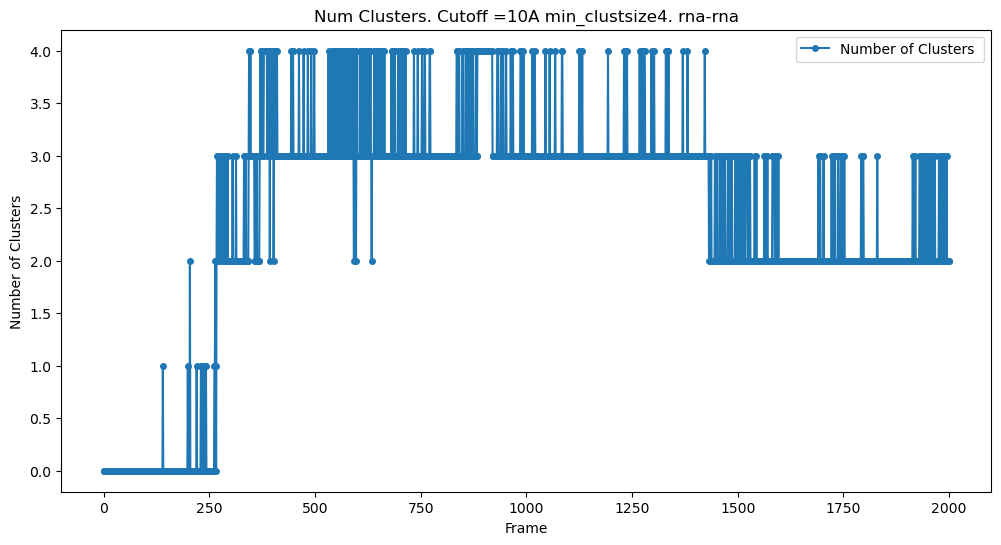

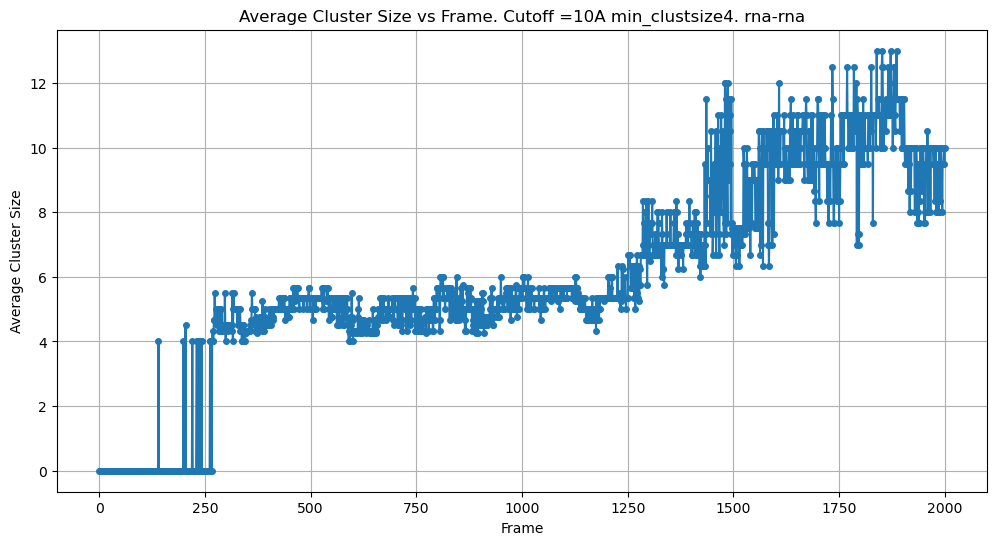

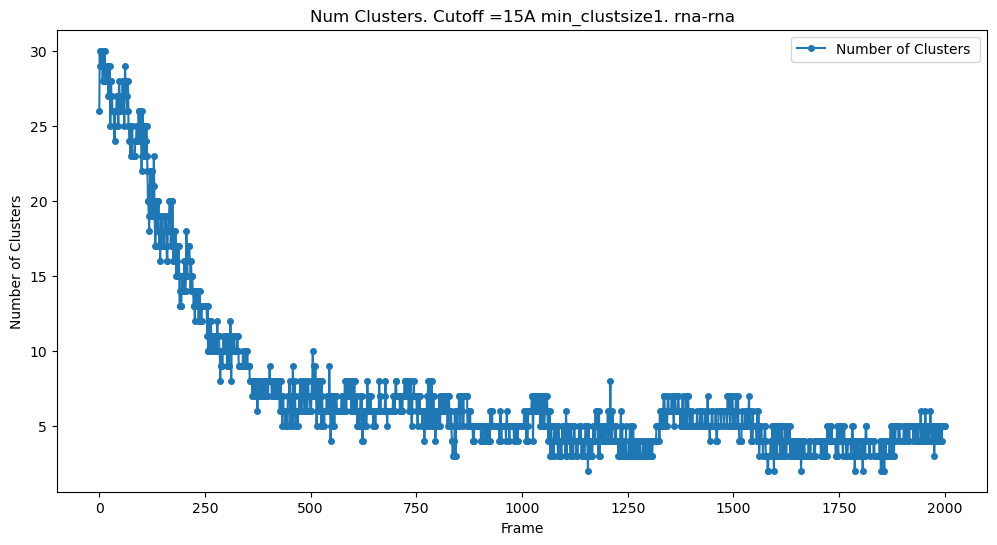

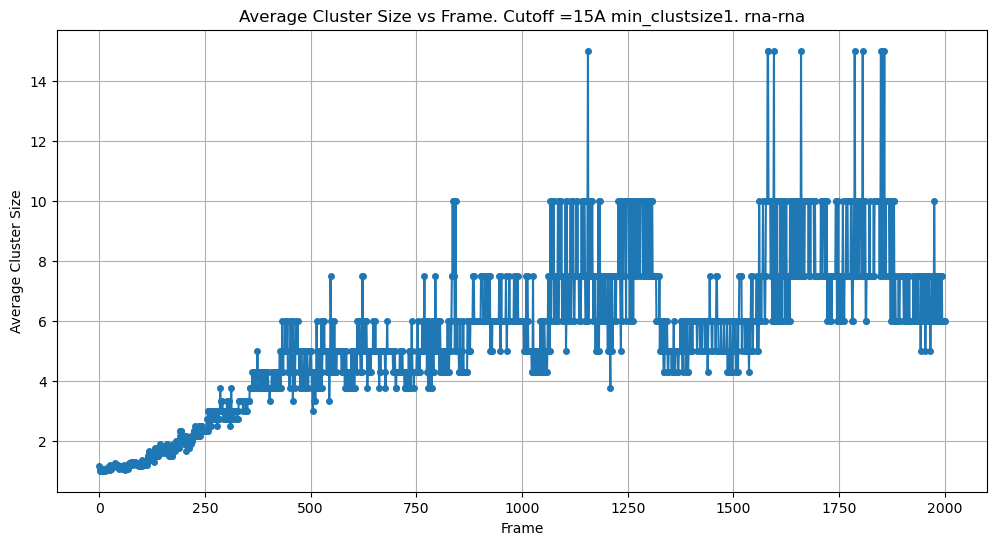

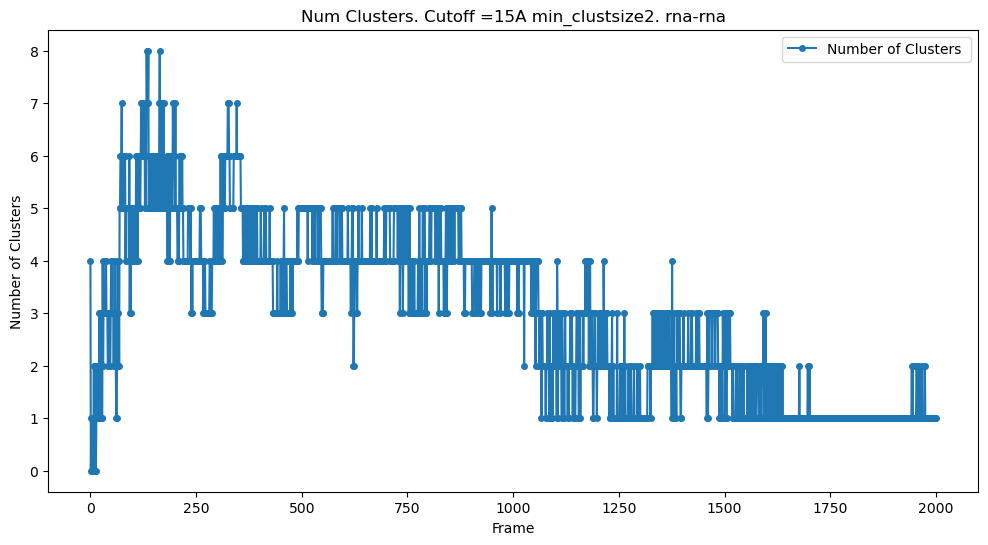

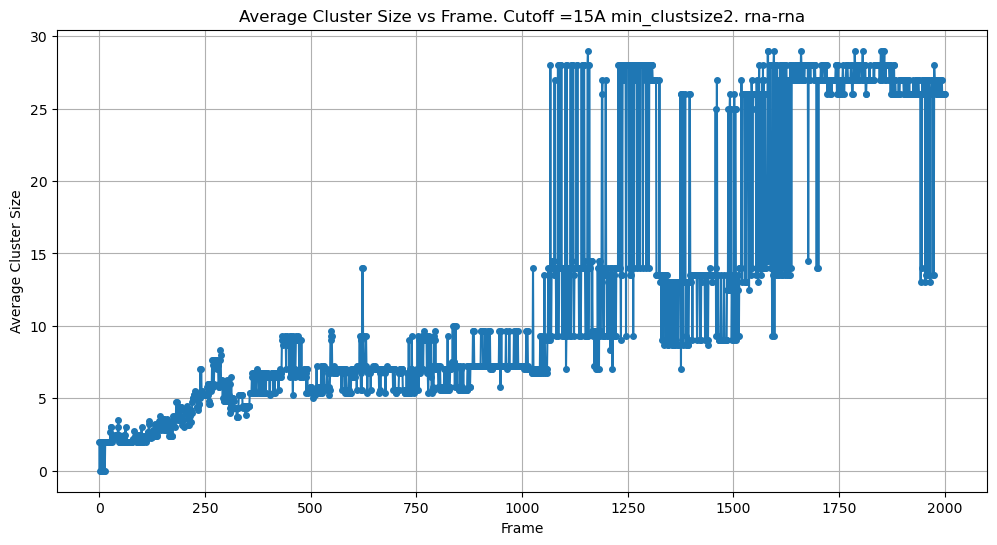

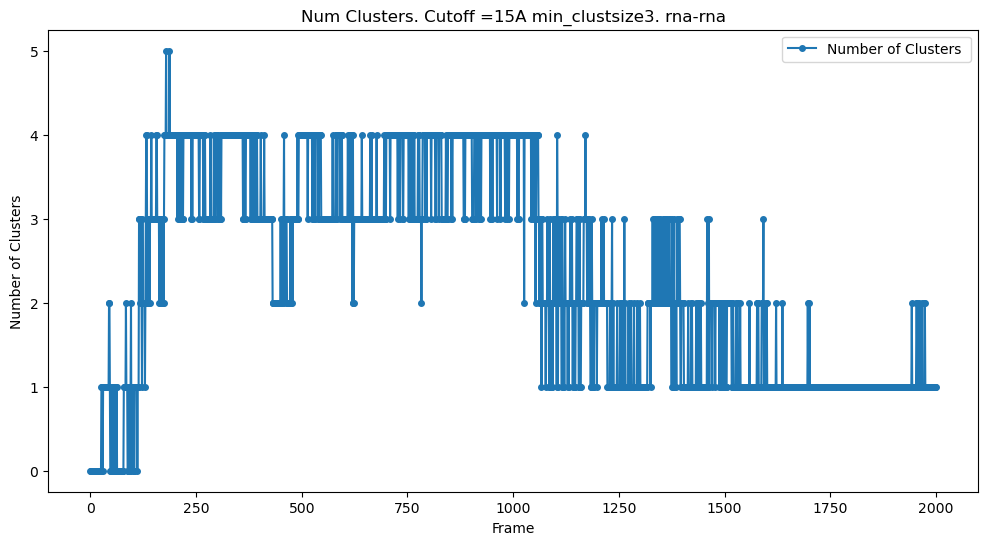

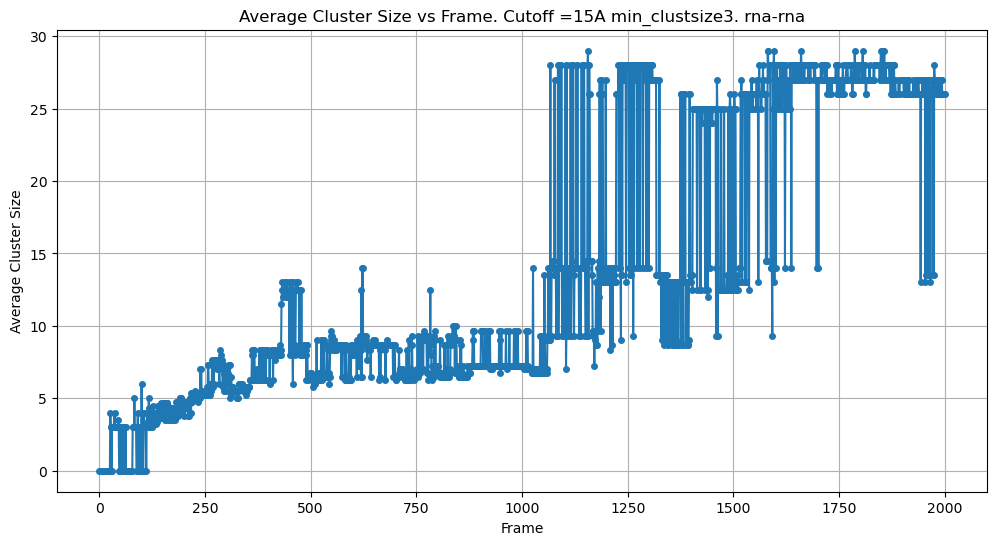

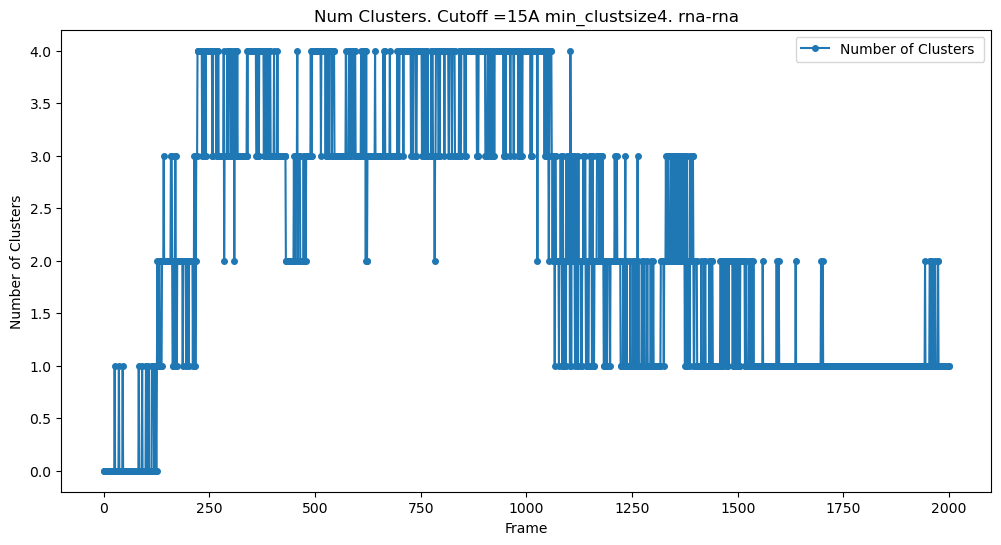

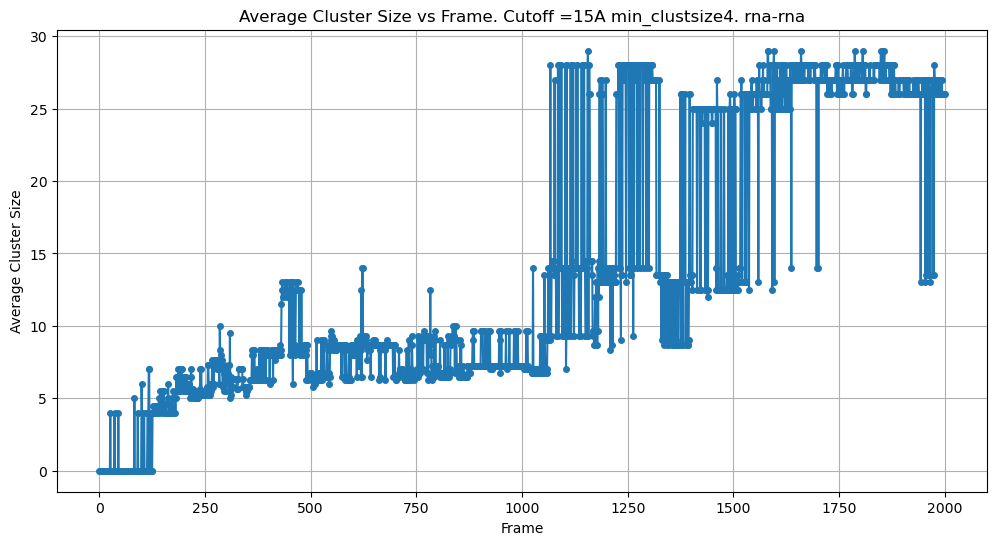

In [4]:
modes = [ "rna-rna"]

cutoffs = [5, 8, 10, 15]
min_clust_sizes = [1, 2, 3, 4]    
u= mda.Universe(gro_file, xtc_file)
print("created Universe")
for mode in modes:
    # the return variable is just so I can later play around with it and visualize it using in matplotlib
    dist_3d_array = run_distance_by_type(mode, len(u.trajectory), cutoffs, min_clust_sizes)

created Universe
running distance calculations foir protein


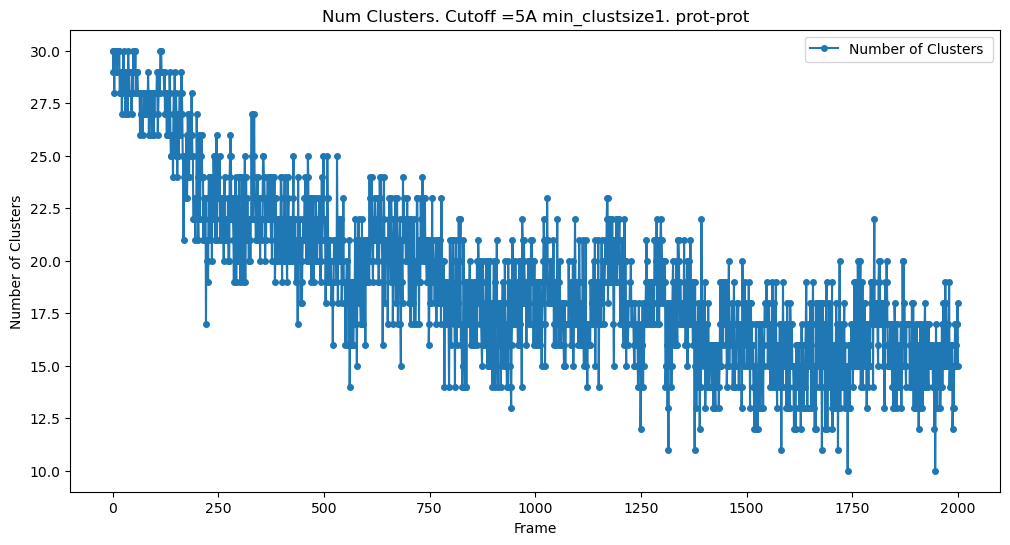

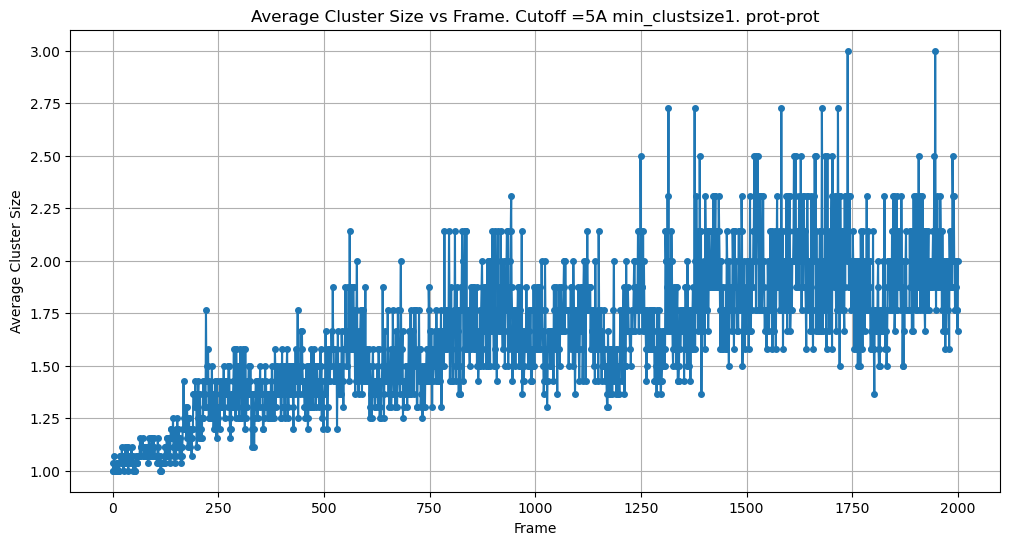

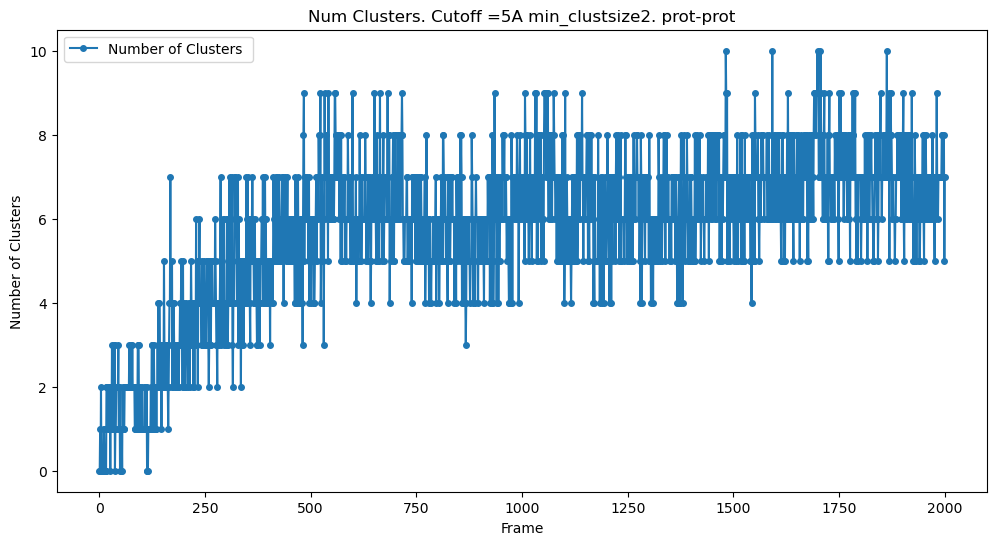

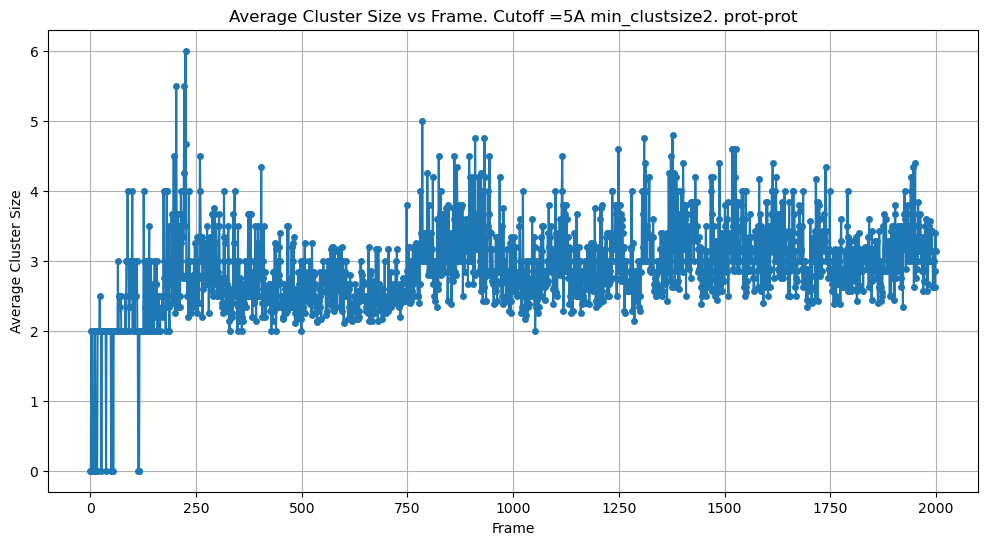

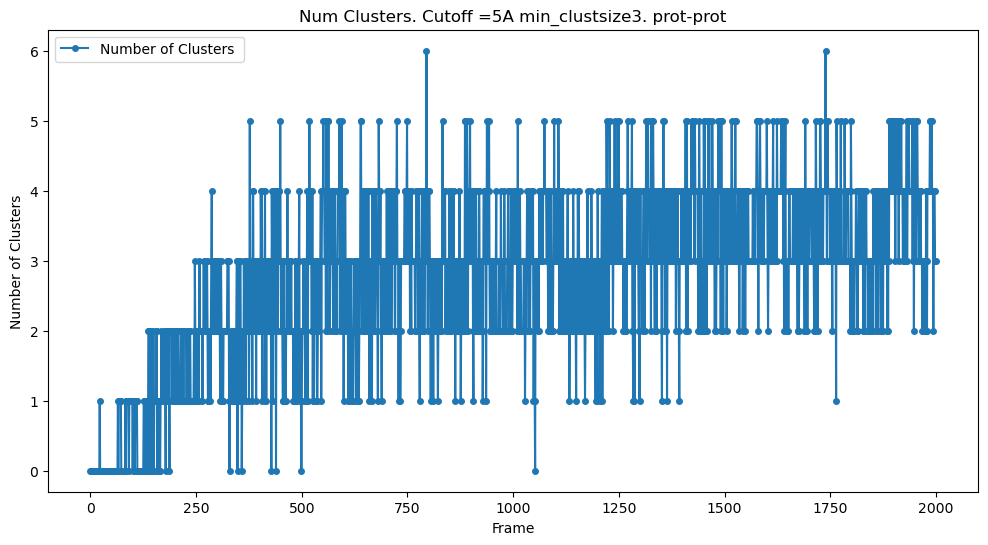

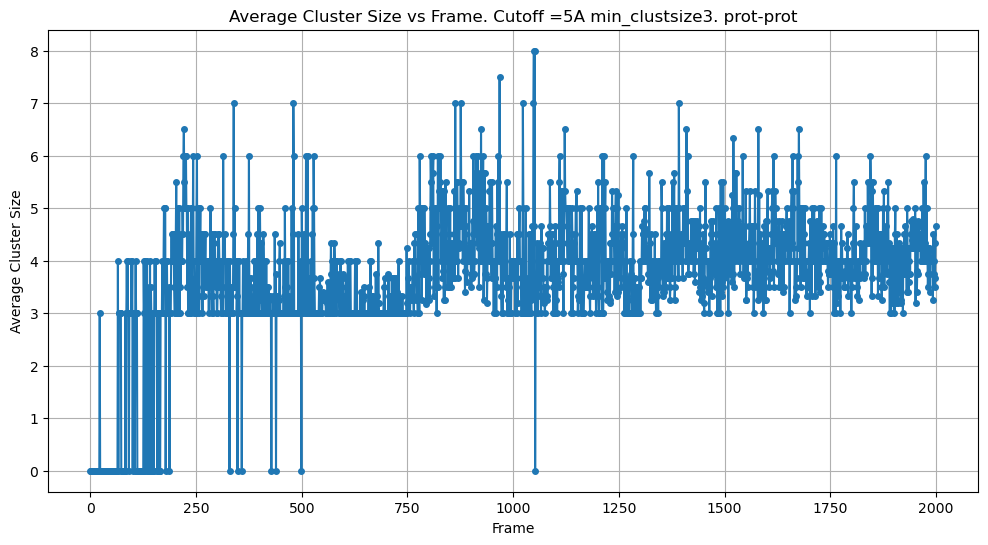

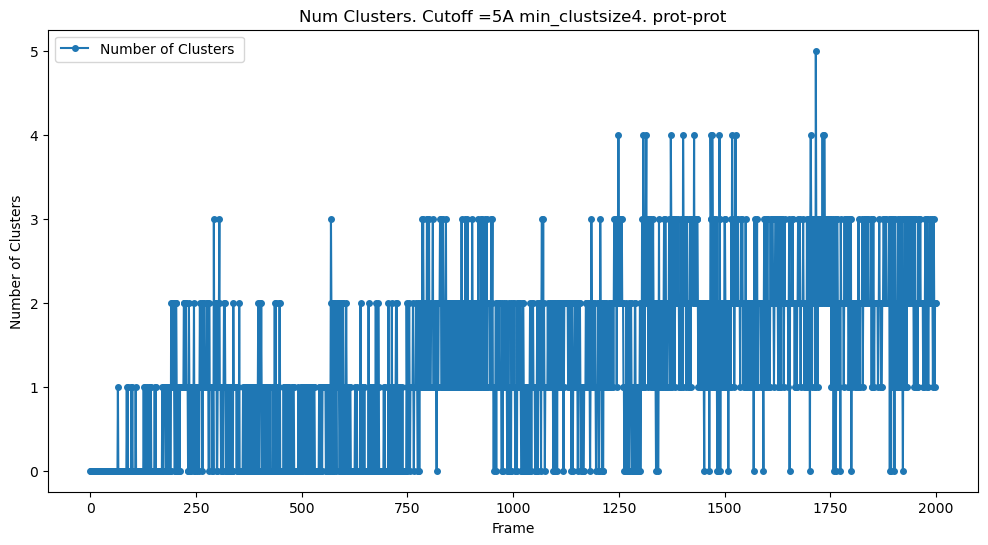

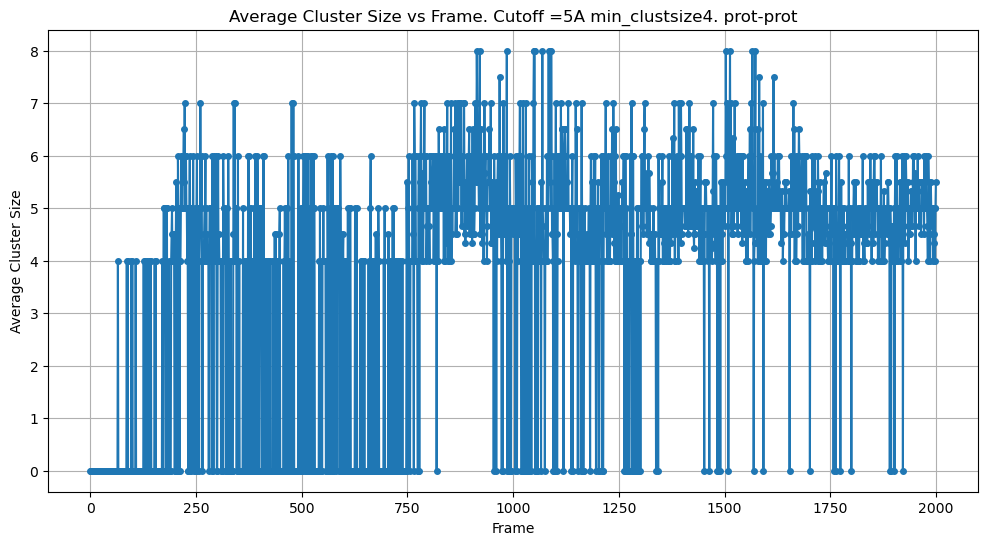

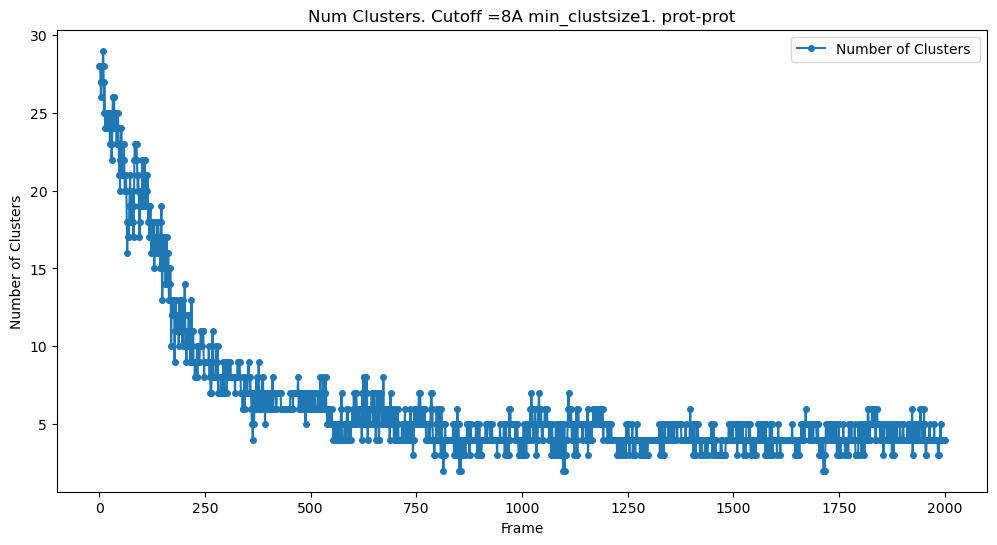

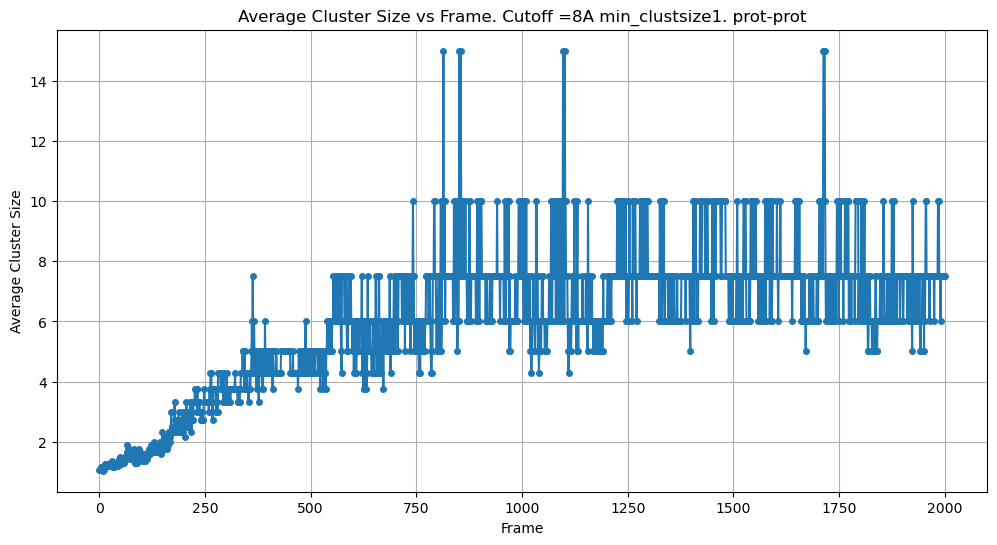

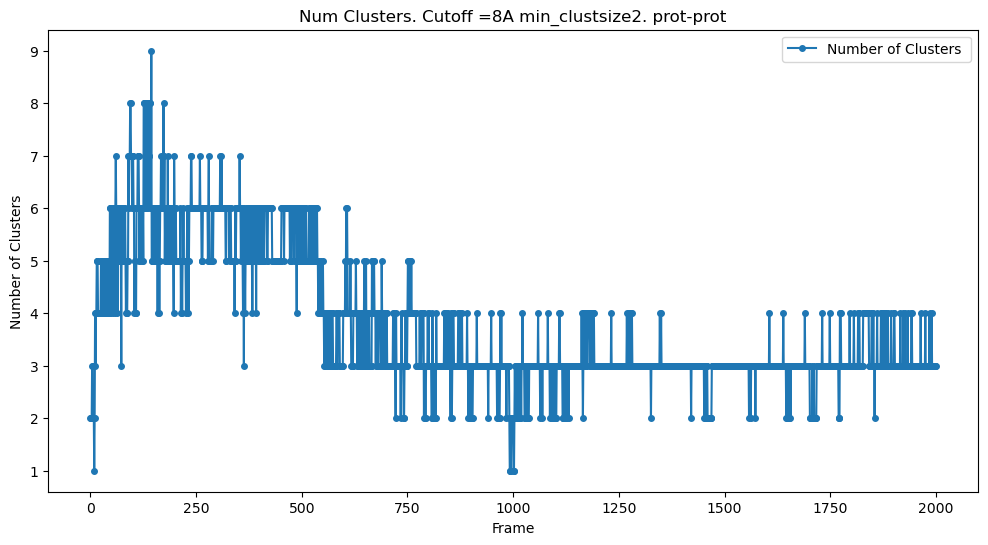

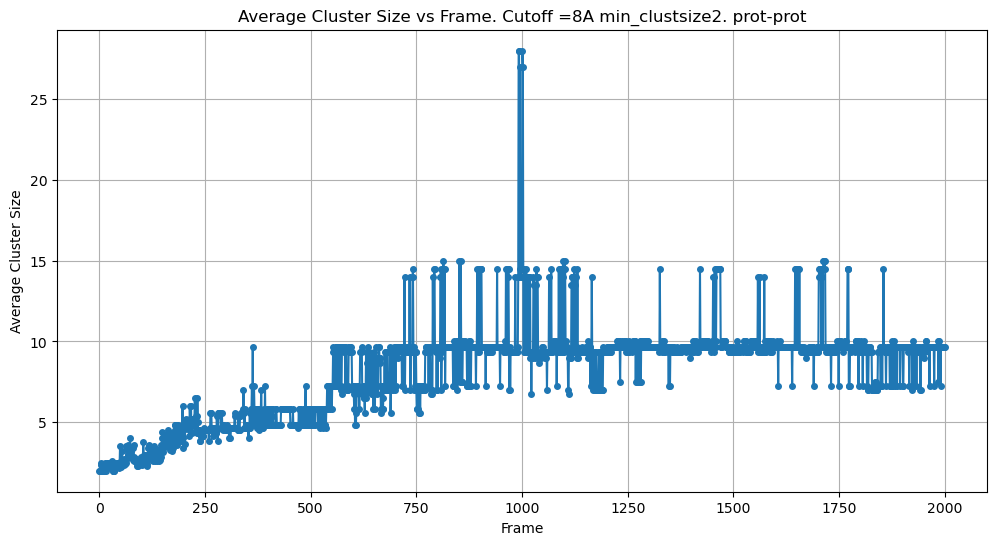

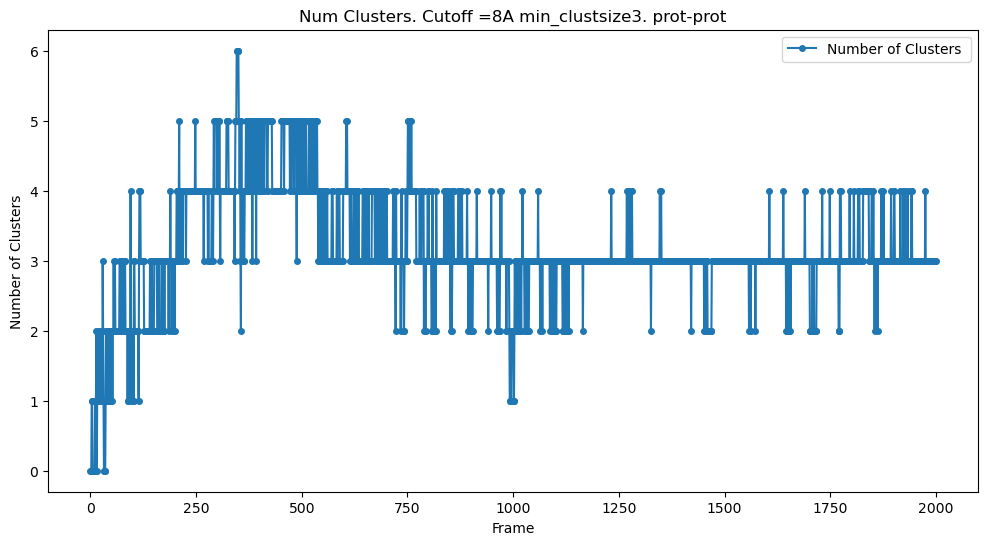

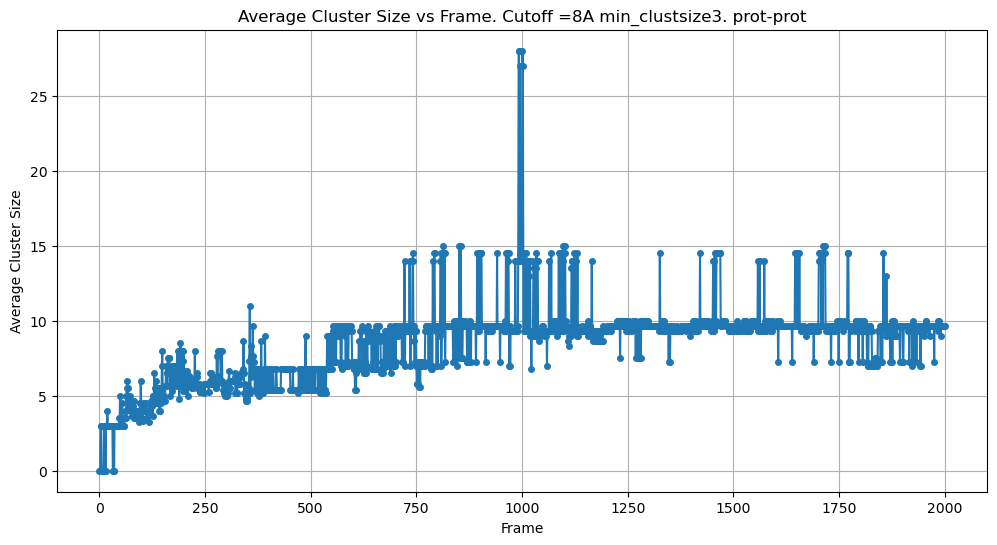

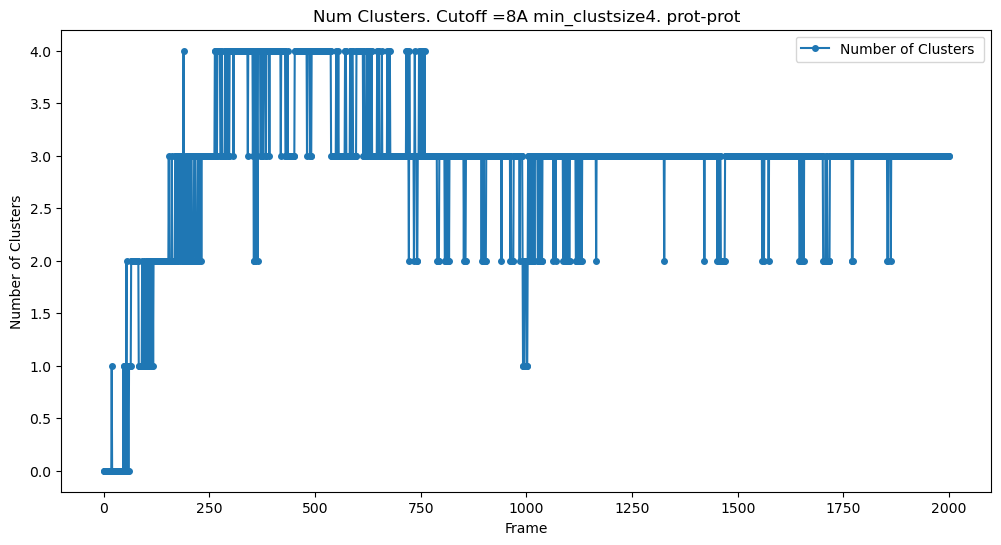

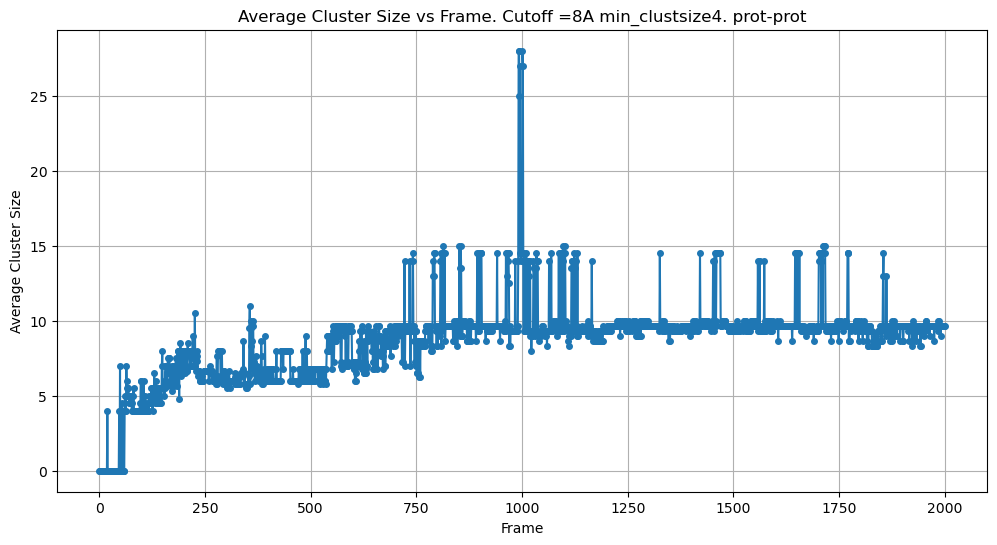

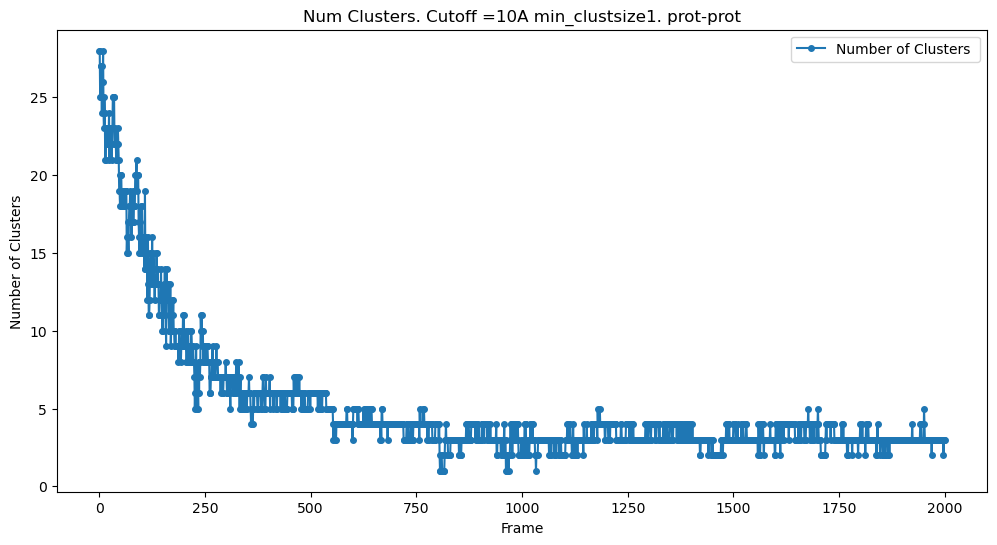

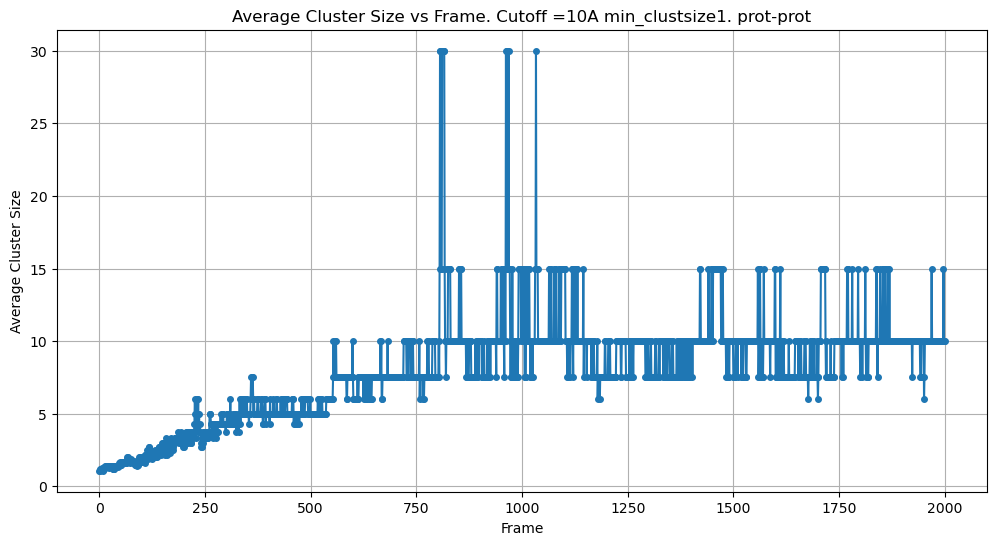

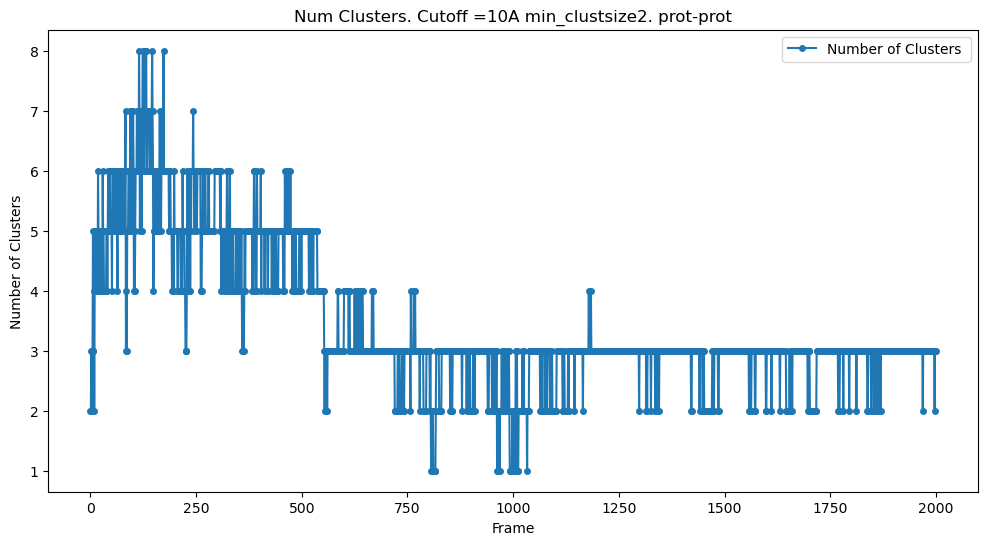

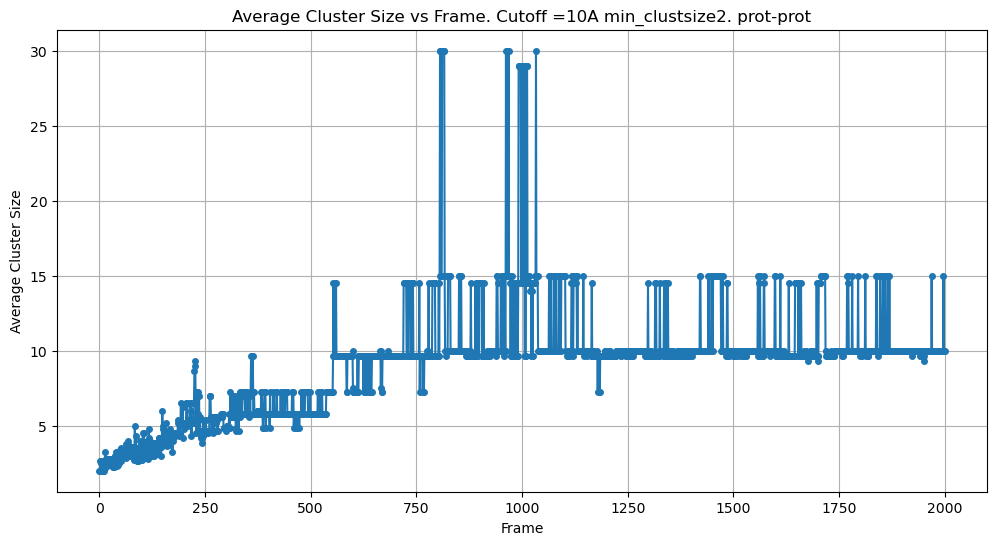

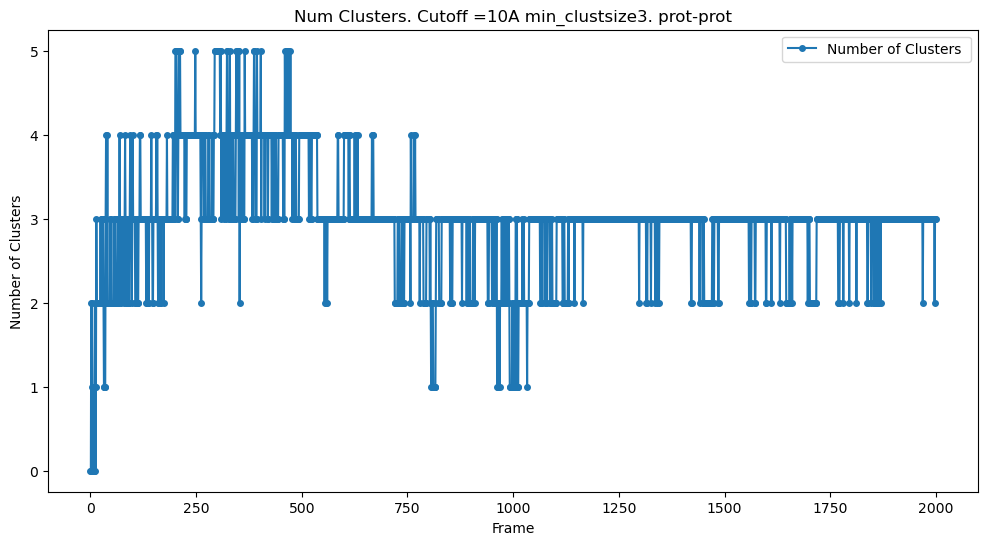

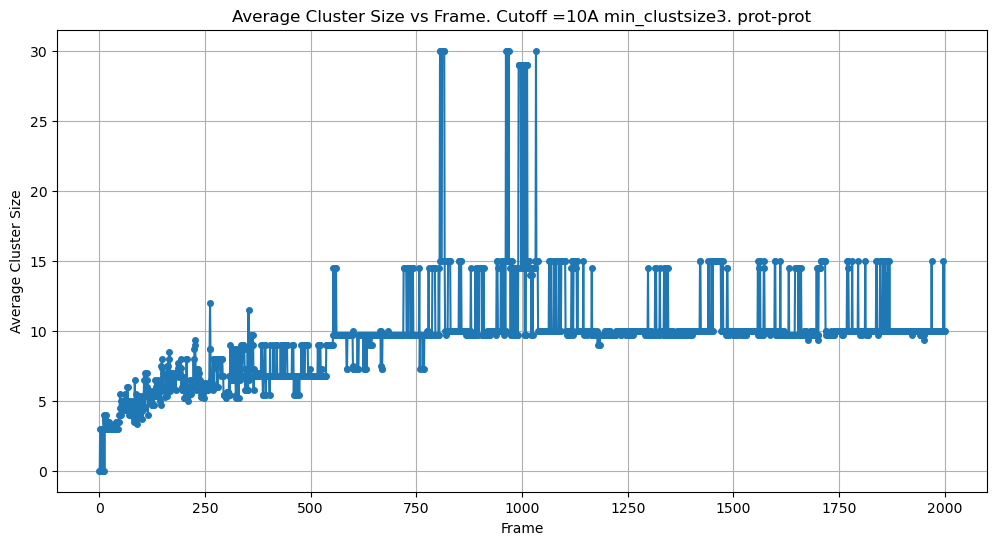

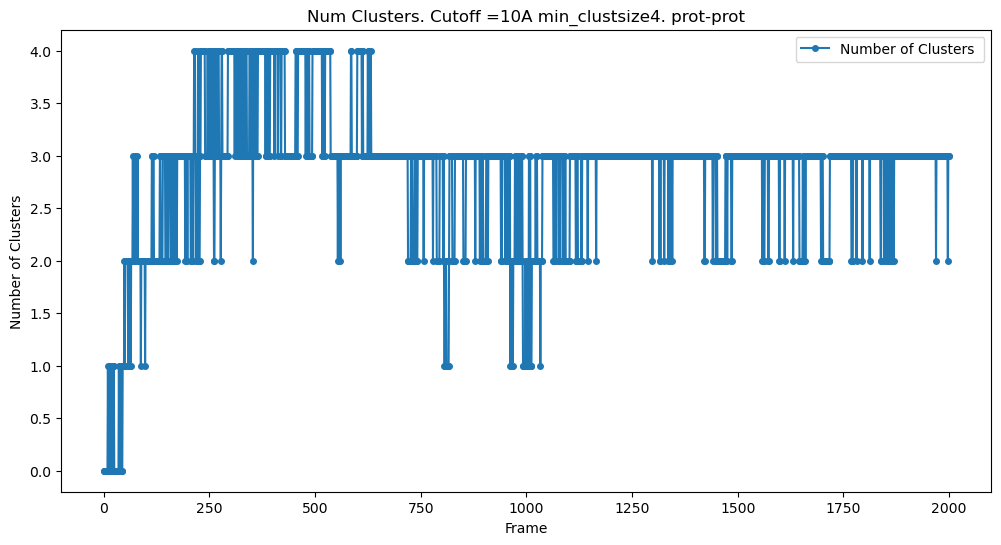

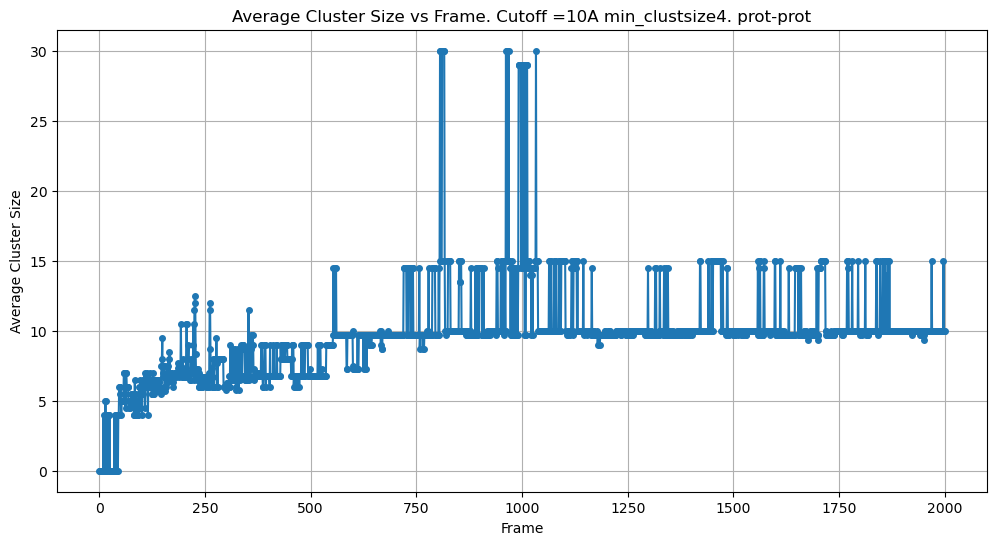

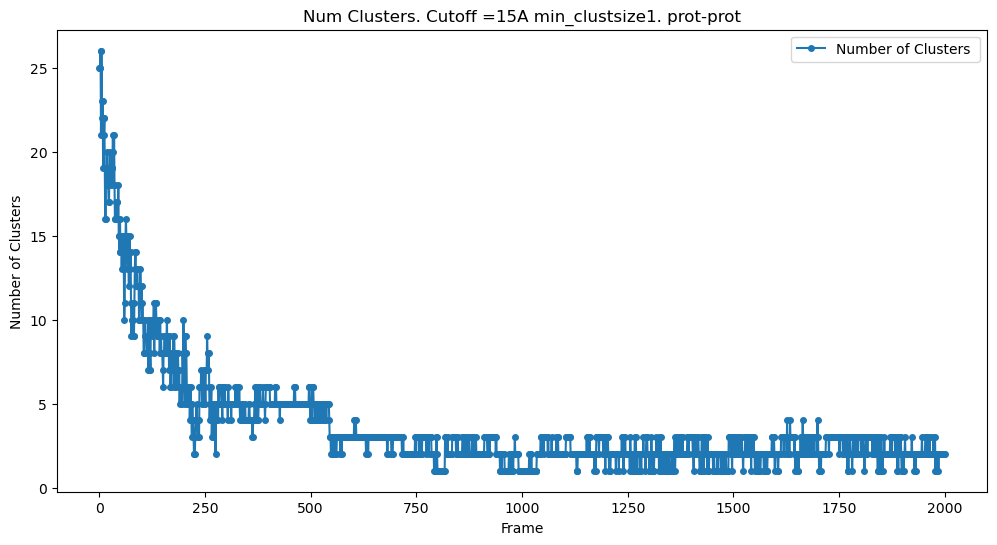

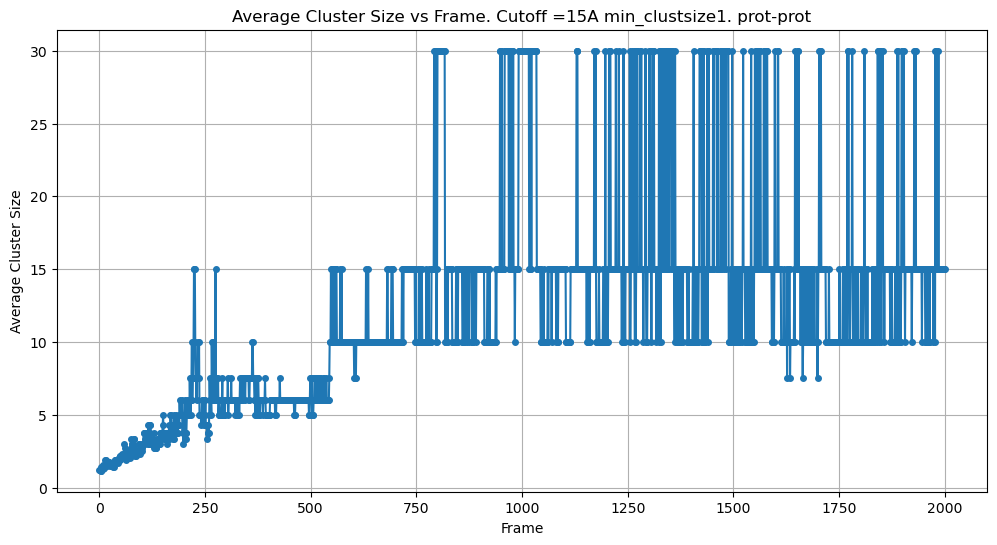

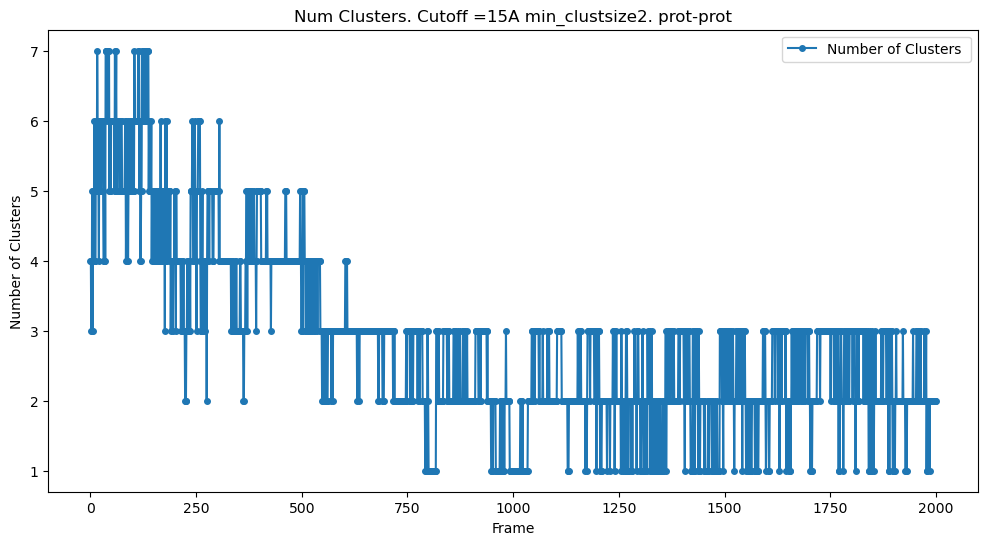

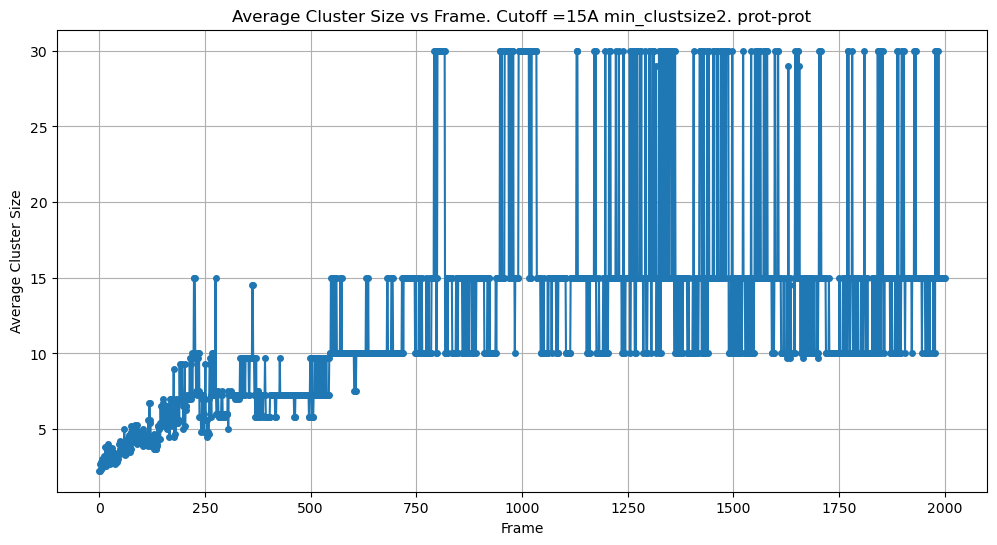

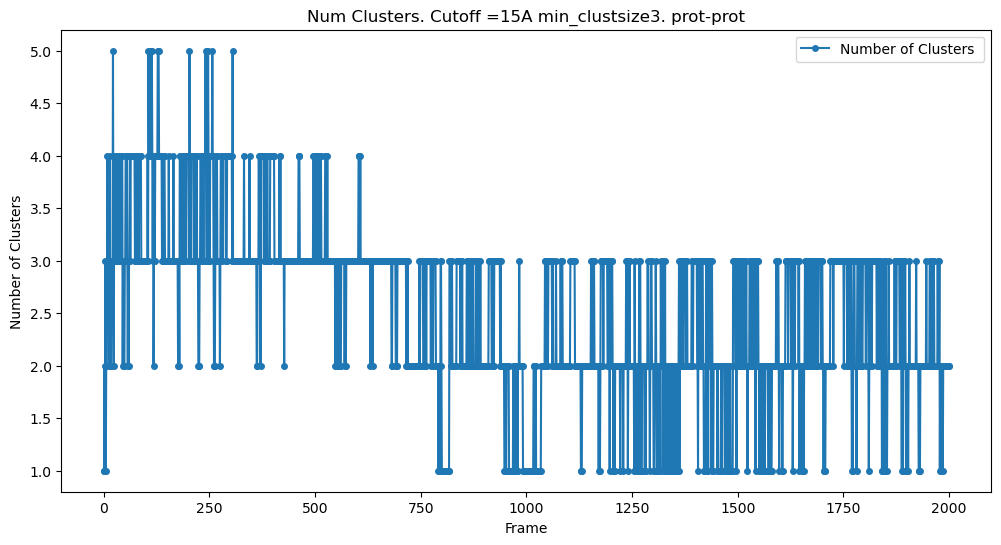

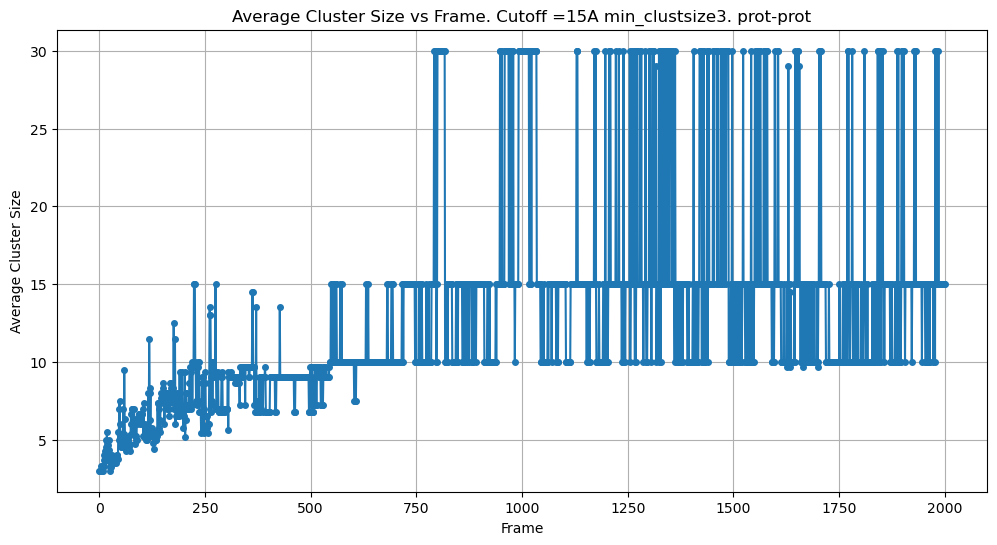

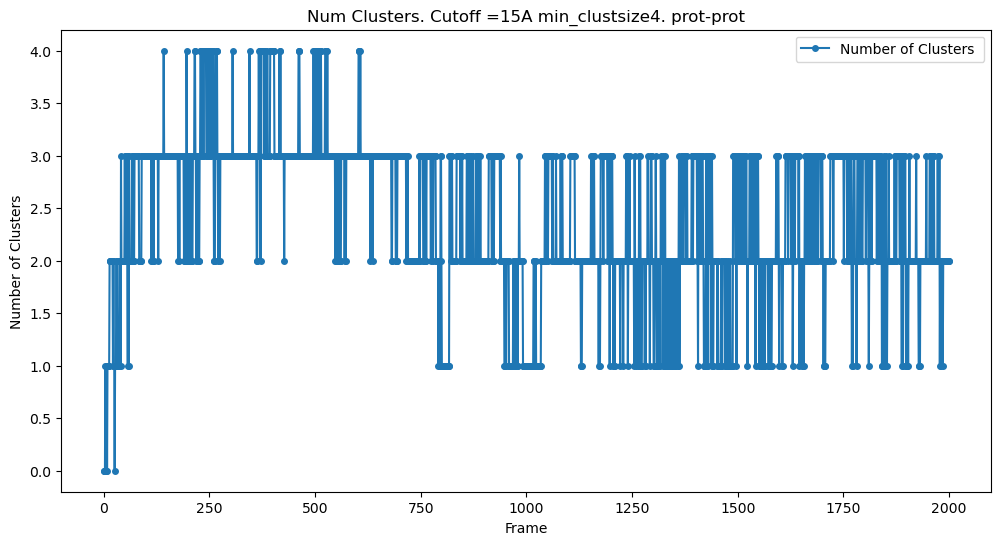

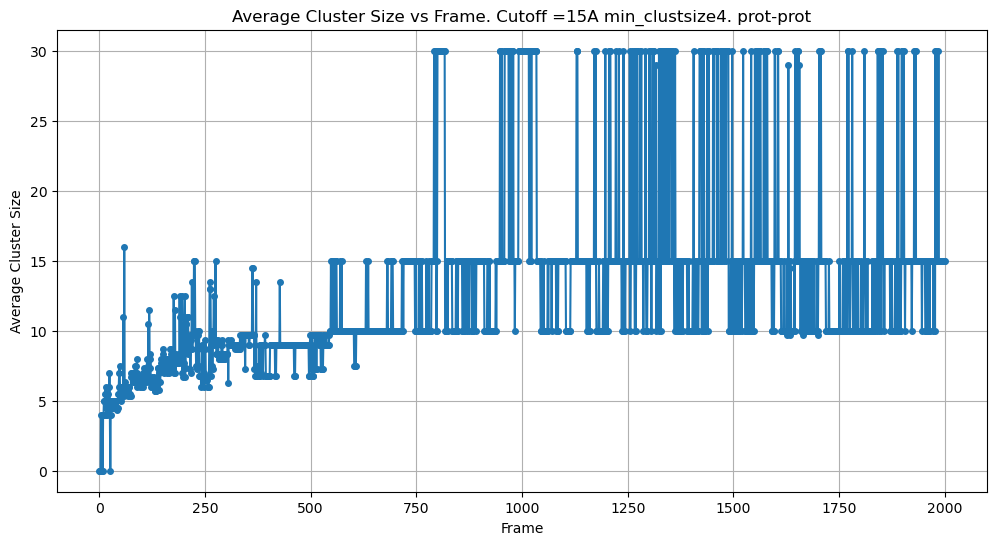

In [5]:
modes = [ "prot-prot"]

cutoffs = [5, 8, 10, 15]
min_clust_sizes = [1, 2, 3, 4]    
u= mda.Universe(gro_file, xtc_file)
print("created Universe")
for mode in modes:
    # the return variable is just so I can later play around with it and visualize it using in matplotlib
    dist_3d_array = run_distance_by_type(mode, len(u.trajectory), cutoffs, min_clust_sizes)